<a href="https://www.kaggle.com/code/arunachal/sentiment-analysis-using-vader-and-textblob?scriptVersionId=139643203" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Problem Statement 3

An e-commerce company wants to analyze customer reviews for its various products. This project undertakes to provide evidence-based insights to identify and segment well-received and ill-received items, so that different
strategies could be devised for each type.

The project, in particular, undertakes the following tasks:

1. Using quantitative data of customers’ reviews, generate useful insights that can be used to separate well and
ill faring items

2. Classify and segment products based on the customers' qualitative reviews and pre-specified quantitative
metrics

In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/reviews/Reviews.csv


In [4]:
# Importing basic libraries

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from datetime import datetime, timedelta
import calendar

import random

plt.style.use('ggplot')
sns.set()
sns.set_style('darkgrid')
sns.set_palette('Set2')

import warnings
warnings.filterwarnings("ignore")

# Importing NLP libraries

import nltk
from textblob import TextBlob, Word
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [5]:
df = pd.read_csv('../input/reviews/Reviews.csv')
df_copy = df.copy()

In [6]:
df.head()

,#NAME?,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [7]:
df.shape

(568454, 10)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   #NAME?                  568454 non-null  int64 
 1   ProductId               568454 non-null  object
 2   UserId                  568454 non-null  object
 3   ProfileName             568438 non-null  object
 4   HelpfulnessNumerator    568454 non-null  int64 
 5   HelpfulnessDenominator  568454 non-null  int64 
 6   Score                   568454 non-null  int64 
 7   Time                    568454 non-null  int64 
 8   Summary                 568427 non-null  object
 9   Text                    568454 non-null  object
dtypes: int64(5), object(5)
memory usage: 43.4+ MB


We can see that the data has,

* **5 quantitative columns** (integer values, no decimals): ‘#NAME?’ (or ID), helpfulness numerator/denominator,
score, and time

* **5 qualitative columns** (string/text type): ProductId, UserId, ProfileName, Text, Summary

### Feature Description  

* Record ID is simply a row index.  
* Product ID identifies a unique product listing. 
* For each user, we have a unique UserId and a profile name. 
* A user’s reviews for a product is given through a text comment and a score (out of 5). The data also contains a timestamp of when the review was recorded. 
* The data contains two pre-specified quantitative columns describing how helpful the user’s reviews are. Presumably, a higher numerator or a lower denominator imply more helpfulness. 
* Finally, for each unique review, we have a pre-specified short text summarising its content.

In [9]:
df.isnull().sum()

#NAME?                     0
ProductId                  0
UserId                     0
ProfileName               16
HelpfulnessNumerator       0
HelpfulnessDenominator     0
Score                      0
Time                       0
Summary                   27
Text                       0
dtype: int64

We find that 16 profile names are missing, and 27 summaries are missing.

In [10]:
df.duplicated().sum()

0

### Data Cleaning and Preprocessing  

We drop,  

a. ‘#NAME?’ or record id column as our key code library Pandas provides an in-built record index.  
b. ProfileName column as UserId anyways uniquely identifies a user.  

We also trim the column names so that they are handy to refer to. Finally, we sort the data in ascending order of
product id, user id, and recording time.

In [11]:
# Dropping irrelevant columns, cleaning column names, removing duplicate rows, sorting

df.drop(columns=['#NAME?', 'ProfileName'], inplace=True)
df.rename(columns={'ProductId': 'pid', 'UserId': 'uid', 'HelpfulnessNumerator': 'h_num', 
                   'HelpfulnessDenominator': 'h_den', 'Score': 'score', 'Time': 'time', 
                   'Summary': 'summary', 'Text': 'text'}, inplace=True)
df.sort_values(['pid', 'uid', 'time'], inplace=True)
df.drop_duplicates(inplace=True)

In [12]:
df.head()

,pid,uid,h_num,h_den,score,time,summary,text
515425,141278509X,AB1A5EGHHVA9M,1,1,5,1332547200,The best drink mix,This product by Archer Farms is the best drink...
24749,2734888454,A13ISQV0U9GZIC,1,1,2,1192060800,made in china,My dogs loves this chicken but its a product f...
24750,2734888454,A1C298ITT645B6,0,0,5,1195948800,Dog Lover Delites,Our dogs just love them. I saw them in a pet ...
308076,2841233731,A3QD68O22M2XHQ,0,0,5,1345852800,Great recipe book for my babycook,This book is easy to read and the ingredients ...
150518,6641040,A12HY5OZ2QNK4N,0,0,5,1256774400,It's a great book!,I've always loved chicken soup and rice. My la...


#### Addressing Duplicates  

We anticipate duplicates of below types.  

a. The same review text, summary, score, etc appear for multiple product ids (pid). This indicates each pid
denotes a distinct product variant listing. Rating for any variant is automatically recorded for all other variants.    

b. A user may review a product variant multiple times, giving either the same or different scores.  

This indicates that we need an informed logic to step-wise eliminate duplicate records.

We create a shorter dataframe for exploratory analysis of scores, with pid, uid, score, and time. 

In [13]:
df1 = df[['pid', 'uid', 'score', 'time']]
df1.duplicated().sum()

3048

In [14]:
df1[df1.duplicated()]

,pid,uid,score,time
171152,7310172001,AJD41FBJD9010,5,1233360000
171188,7310172001,AJD41FBJD9010,5,1233360000
171222,7310172001,AJD41FBJD9010,5,1233360000
171227,7310172001,AJD41FBJD9010,5,1233360000
217383,7310172101,AJD41FBJD9010,5,1233360000
...,...,...,...,...
445222,B009GHI5Q4,A3TVZM3ZIXG8YW,1,1291420800
67514,B009GHI6I6,A2ISKAWUPGGOLZ,1,1310774400
67515,B009GHI6I6,A3TVZM3ZIXG8YW,1,1291420800
417990,B009RB4GO4,A1FQSVI2WVV5W5,1,1319760000


We again find 3048 entire duplicate rows. We can drop them without incurring any information loss.

In [15]:
df1.drop_duplicates(inplace=True)
df1.duplicated().sum()

0

We next identify entries such as one below.

In [16]:
# Same users giving the same score at the same time to multiple products

df1[df1.duplicated(['uid', 'score', 'time'])].sort_values('uid')[1:3]

,pid,uid,score,time
290947,B005HG9ESG,#oc-R11D9D7SHXIJB9,5,1342396800
496893,B005HG9ET0,#oc-R11D9D7SHXIJB9,5,1342396800


In [17]:
df1.duplicated(['uid', 'score', 'time']).sum()

197072

There are 0.197 million entries like the one above showing the same user rating a product variant at a specific time and
the same rating being logged for all other variants.

We can drop the variant pids and take just one unique variant for each product type for our analysis. As the
scores and reviews for all variants are the same, our conclusions will also hold for the eliminated variants.  

At the same time, we keep aside a static mapping of all product variants and a representative variant we select for analysis. As default, we select the first occurring variant in the sorted dataframe.

In [18]:
df1.drop_duplicates(['uid', 'score', 'time'], inplace=True)
df1.duplicated(['uid', 'score', 'time']).sum()

0

Next, we find entries like the one below.

In [19]:
df1[df1.duplicated(['pid', 'uid'])].sort_values(['pid', 'uid'])

,pid,uid,score,time
171182,7310172001,AE9ZBY7WW3LIQ,1,1219363200
374411,B00004CI84,A1K94LXX833JTT,4,1213747200
479731,B00005U2FA,A1B226ZPOE0KSZ,3,1070496000
369816,B000084DWM,A2YIP1EF88XCDV,4,1312156800
369836,B000084DWM,A966L65JSN8XN,5,1323820800
...,...,...,...,...
504590,B007I7YZJK,AXOO7BPM22BDO,5,1334016000
25074,B0081XIA1E,A3O8ZBW077S3K6,1,1333152000
25192,B0081XIA1E,AFPJ42B9RTEZP,2,1343174400
287838,B008NVG8NQ,A3HPCRD9RX351S,5,1346112000


In [20]:
df1.duplicated(['pid', 'uid']).sum()

838

These are instances when the same user gives different ratings to the same product variant at different times.  
These ratings, given at different times, could be both same or different.   
In such cases, we can keep the last recorded rating and drop all previous records.

In [21]:
df1.drop_duplicates(['pid', 'uid'], keep='last', inplace=True)
df1.duplicated(['pid', 'uid']).sum()

0

We run a final check to confirm that there are no important redundancies in the data.

In [22]:
df1.duplicated().sum()

0

In [23]:
df1.duplicated(['pid', 'uid', 'score']).sum()

0

### Exploratory Data Analysis  

At this stage, we perform an exploration of scores of each representative product variant selected in the
previous step.  

For this, we set up our dataframe as follows. For each unique product id, we append,  

a. Total reviews recorded for each unique product variant (pid).  
b. Percentage frequencies with which it was rated 1, 2, 3, 4, or 5.  
c. Frequency-weighted mean rating for each product, and the most frequent (mode) rating it received.  
d. Encode mean rating as a category column (>1, >2, >3, >4).  
e. Insert 2 extra columns with sums of %age reviewers giving scores ‘1+2’ (combined) and ‘4+5’ (combined).  

In [24]:
# Finding total review counts for each product

p_total_counts = df1.pivot_table(index='pid', values='uid', aggfunc='count').sort_values('uid', ascending=False)
p_total_counts.rename({'uid': 'Review Counts'}, axis=1, inplace=True)

In [25]:
# Finding distribution of ratings (1-5) for each product

p_scores = pd.DataFrame(index=p_total_counts.index, columns = range(1, 6))

for idx in p_scores.index:   
    
    t = df1[df1['pid'] == idx]['score']
    t = ((100*t.value_counts().sort_index())/len(t)).astype('int64').to_dict()
    
    for key, value in t.items():
                
        p_scores.loc[idx, key] = value    

In [26]:
# Appending additional columns for total, mean, and mode review scores

p_df = p_scores.copy()
p_df = pd.concat([p_total_counts, p_df], axis=1)
p_df.rename({'Review Counts': 'reviews'}, axis=1, inplace=True)
p_df.fillna(0, inplace=True)
p_df['mean'] = (1*p_df[1] + 2*p_df[2] + 3*p_df[3] + 4*p_df[4] + 5*p_df[5])/100
p_df['mode'] = p_df[[1, 2, 3, 4, 5]].astype('float').idxmax(axis=1)

In [27]:
def encode_mean(x):
    
    if (x >= 4) & (x <= 5):        
        return '4-5'
    
    elif (x > 3) & (x <= 4):        
        return '3-4'
    
    elif (x > 2) & (x <= 3):        
        return '2-3'
    
    elif (x > 1) & (x <= 2):        
        return '1-2'
    
    elif (x > 0) & (x <= 1):        
        return '0-1'

In [28]:
p_df['mean_cat'] = p_df['mean'].apply(encode_mean)
p_df['1+2'] = p_df[1] + p_df[2]
p_df['4+5'] = p_df[4] + p_df[5]

The final table, ready for summarizing, lists around 65000 unique pids, and appears as below.

In [29]:
p_df.shape

(64866, 11)

In [30]:
p_df.head()

,reviews,1,2,3,4,5,mean,mode,mean_cat,1+2,4+5
pid,,,,,,,,,,,
B007JFMH8M,905,0,1,5,23,68,4.49,5,4-5,1,91
B003B3OOPA,579,0,1,3,11,82,4.65,5,4-5,1,93
B0026RQTGE,571,4,1,3,11,78,4.49,5,4-5,5,89
B000KV61FC,542,16,14,18,16,33,3.27,5,3-4,30,49
B000VK8AVK,536,5,5,8,16,64,4.23,5,4-5,10,80


We can get an overall summary as shown below.

In [31]:
p_df.describe()

,reviews,1,2,3,4,5,mean,mode,1+2,4+5
count,64866.000000,64866.000000,64866.000000,64866.000000,64866.000000,64866.000000,64866.000000,64866.000000,64866.000000,64866.000000
mean,5.661132,10.582863,5.448232,7.167314,12.852974,63.617565,4.124810,4.153008,16.031095,76.470539
std,17.887749,24.693998,17.601507,20.095485,25.958507,38.413393,1.101489,1.398970,29.333371,33.696619
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000,0.000000,0.000000,33.000000,3.630000,4.000000,0.000000,62.000000
50%,2.000000,0.000000,0.000000,0.000000,0.000000,75.000000,4.500000,5.000000,0.000000,100.000000
75%,4.000000,4.000000,0.000000,0.000000,14.000000,100.000000,5.000000,5.000000,20.000000,100.000000
max,905.000000,100.000000,100.000000,100.000000,100.000000,100.000000,5.000000,5.000000,100.000000,100.000000


We observe,  

a. 75% items have less than 4 reviews, which can be insufficient to draw robust conclusions. Yet, some items
have more than 500, up to 905 reviews. On average, items have received 5.7 reviews.  

b. Up to 75% items have received 0 instances of scores 1, 2, 3. Up to 75% items, the percentage frequency of
score 4 is 14, and that of score 5 is 33.  

c. Even the lowest quartile of items have received scores 4 or 5 with 62% frequency. In contrast, the bottom 3
quartiles of items have received scores 1 or 2 with 20% frequency.  

d. The mean, median, and mean of mode scores across all products are 4.12, 4.5, and 4.15 respectively. This
shows that while reviews are less, many items have received scores 4 or 5.  

e. Extreme ratings (1, 4, 5) also have a high standard deviation.


We further find that,  

* Most items have total reviews within 0-100.   
* Reviews beyond 200 in number are received only by isolated items.   

These are corroborated by the plots and the tables below.

In [32]:
p_df[p_df['reviews']<5]

,reviews,1,2,3,4,5,mean,mode,mean_cat,1+2,4+5
pid,,,,,,,,,,,
B001AY9SAS,4,0,0,0,25,75,4.75,5,4-5,0,100
B00570J7IE,4,0,0,0,0,100,5.00,5,4-5,0,100
B0049D3UF6,4,0,0,0,25,75,4.75,5,4-5,0,100
B001SB6AB8,4,0,25,50,0,25,3.25,3,3-4,25,25
B000BQSI1G,4,25,25,25,25,0,2.50,1,2-3,50,25
...,...,...,...,...,...,...,...,...,...,...,...
B0025UCCYK,1,0,0,0,0,100,5.00,5,4-5,0,100
B0025UCB9Q,1,0,0,0,100,0,4.00,4,4-5,0,100
B0025UCAKG,1,0,0,0,0,100,5.00,5,4-5,0,100


In [33]:
p_df['mean_cat'].value_counts()

4-5    45447
3-4     7828
2-3     5975
0-1     3387
1-2     2229
Name: mean_cat, dtype: int64

Text(0.5, 1.0, 'Number of Products Getting Different Reviews')

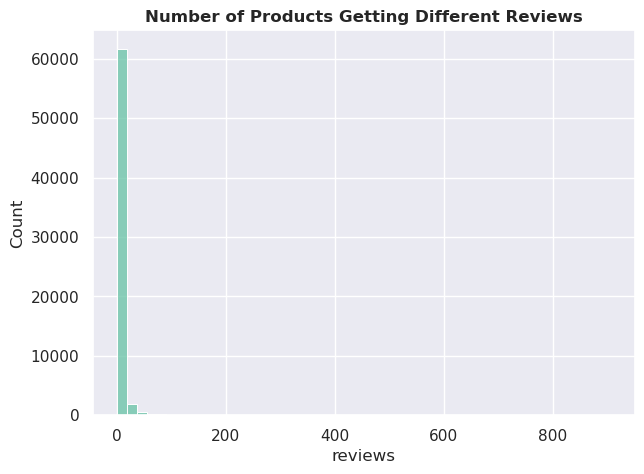

In [34]:
plt.figure(figsize=(7, 5))
sns.histplot(data=p_df, x='reviews', bins=50)
plt.title('Number of Products Getting Different Reviews', fontweight='bold')

Text(0.5, 1.0, 'Variation in Review Counts for Different Products')

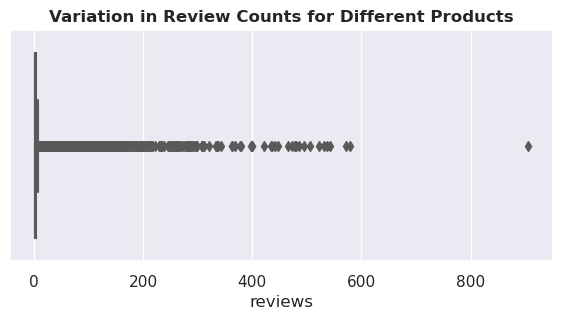

In [35]:
plt.figure(figsize=(7, 3))
sns.boxplot(data=p_df, x='reviews', orient='h')
plt.title('Variation in Review Counts for Different Products', fontweight='bold')

Text(0.5, 1.0, 'Number of Products Getting Different Reviews [Total Reviews < 100]')

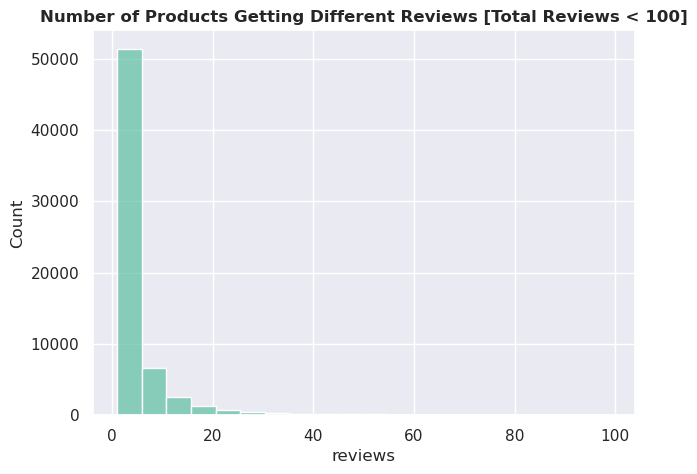

In [36]:
plt.figure(figsize=(7, 5))
sns.histplot(data=p_df[p_df['reviews'] < 100], x='reviews', bins=20)
plt.title('Number of Products Getting Different Reviews [Total Reviews < 100]', fontweight='bold')

Text(0.5, 1.0, 'Variation in Review Counts for Different Products [Total Reviews < 100]')

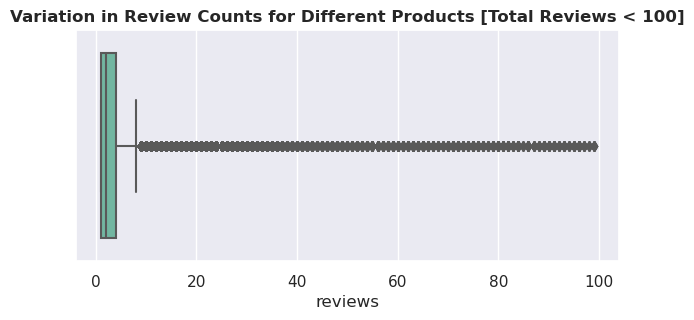

In [37]:
plt.figure(figsize=(7, 3))
sns.boxplot(data=p_df[p_df['reviews'] < 100], x='reviews', orient='h')
plt.title('Variation in Review Counts for Different Products [Total Reviews < 100]', fontweight='bold')

Text(0.5, 1.0, 'Number of Products Getting Different Reviews [10 < Total Reviews < 50]')

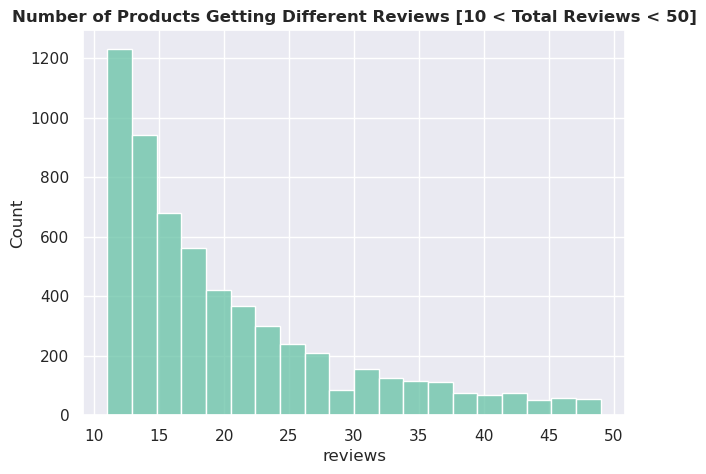

In [38]:
plt.figure(figsize=(7, 5))
sns.histplot(data=p_df[(p_df['reviews'] > 10) & (p_df['reviews'] < 50)], x='reviews', bins=20)
plt.title('Number of Products Getting Different Reviews [10 < Total Reviews < 50]', fontweight='bold')

Text(0.5, 1.0, 'Variation in Review Counts for Different Products [10 < Total Reviews < 50]')

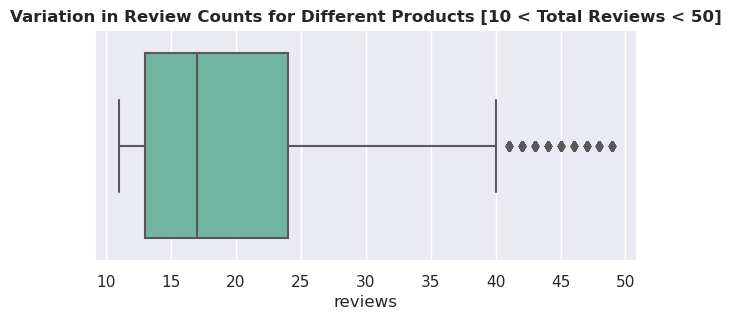

In [39]:
plt.figure(figsize=(7, 3))
sns.boxplot(data=p_df[(p_df['reviews'] > 10) & (p_df['reviews'] < 50)], x='reviews', orient='h')
plt.title('Variation in Review Counts for Different Products [10 < Total Reviews < 50]', fontweight='bold')

This suggests that a majority of items have got less than 25 reviews.  
We can show how the % of items which got a review falls sharply as we increase the number of reviewing users.

<Axes: title={'center': '% Products Reviewed by More Than Different Numbers of Users'}, xlabel='Number of Users Reviewing'>

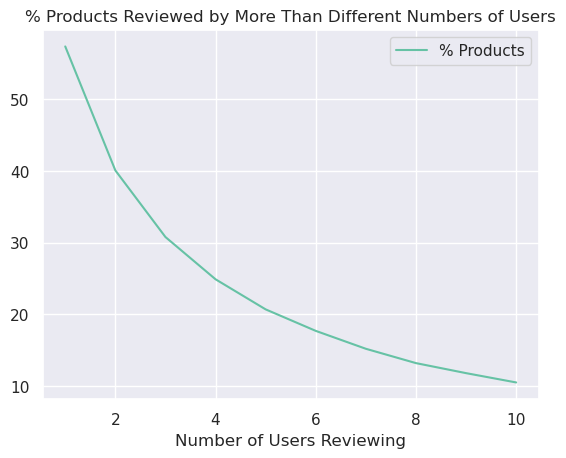

In [40]:
p_review_drop = pd.DataFrame(index=range(0, 11))
p_review_drop.index.name = 'Number of Users Reviewing'

for i in range(1, 11):
    
    p_review_drop.loc[i, '% Products'] = round((100*len(p_df[p_df['reviews'] > i]))/len(p_df), 1)
    
p_review_drop.plot(title='% Products Reviewed by More Than Different Numbers of Users')

We see that while all products got reviewed once, their fraction falls sharply as we look for items with more user
reviews.  
Next, we check the distribution of mean and mode ratings.

In [41]:
p_df['mean_cat'].value_counts()

4-5    45447
3-4     7828
2-3     5975
0-1     3387
1-2     2229
Name: mean_cat, dtype: int64

Text(0.5, 1.0, '% Products with Mean Ratings in Different Ranges\n')

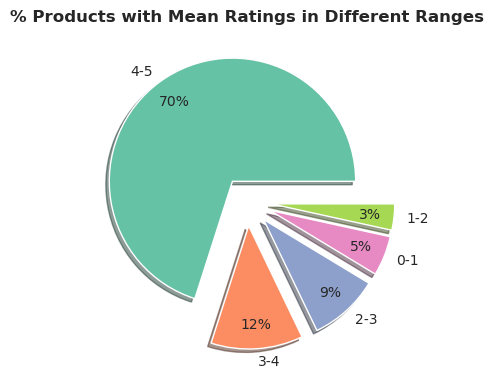

In [42]:
plt.figure(figsize=(4, 4))
plt.pie(p_df['mean_cat'].value_counts(), labels=p_df['mean_cat'].value_counts().index, autopct='%1.0f%%', pctdistance=0.8, shadow=True, explode=0.2*np.ones(5),textprops={'fontsize': 10})
plt.title('% Products with Mean Ratings in Different Ranges\n', fontweight='bold', fontsize=12)

In [43]:
p_df['mode'].value_counts()

5    43168
1     7605
4     6878
3     4002
2     3213
Name: mode, dtype: int64

Text(0.5, 1.0, '% Products with Different Mode Ratings\n')

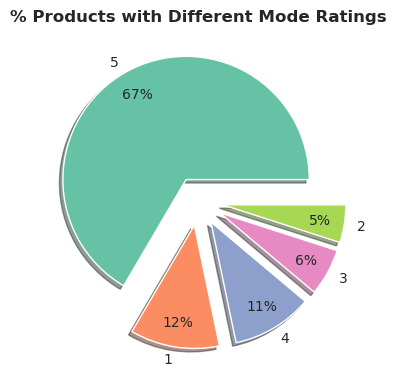

In [44]:
plt.figure(figsize=(4, 4))
plt.pie(p_df['mode'].value_counts(), labels=['5', '1', '4', '3', '2'], autopct='%1.0f%%', pctdistance=0.8, shadow=True, explode=0.2*np.ones(5),textprops={'fontsize': 10})
plt.title('% Products with Different Mode Ratings\n', fontweight='bold', fontsize=12)

We note that most reviews given include a score of 5. Among other scores, a significant number of items have
received a score of 1.  

Mean scores are more relevant if they are accompanied by high review counts. We can classify our products as,  

* **Best performing**: High review count, High mean/median score
* **Worst performing**: High review count, Low mean/median score  

So, we next sort the products in descending order of mean scores and review counts.

In [45]:
p_df[['mean', 'reviews']].sort_values(['mean', 'reviews'], ascending=[False, False]).head(10)

,mean,reviews
pid,,
B000RL53PE,5.0,33
B005EL6VOY,5.0,30
B001IZ9ME6,5.0,29
B00376ZEY6,5.0,28
B0029O0XGQ,5.0,28
B0016BS3BK,5.0,25
B000LKZCQQ,5.0,24
B001E5DYEE,5.0,23
B000KXZ8E0,5.0,23


We list the top 10 items with highest mean scores in different review count ranges below.

In [46]:
p_df[p_df['reviews']>500][['mean', 'reviews']].sort_values(['mean', 'reviews'], ascending=[False, False]).head(10).style.set_caption('Items with Highest Mean Scores [Reviews > 500]')

,mean,reviews
pid,,
B001EO5Q64,4.660000,531
B003B3OOPA,4.650000,579
B007JFMH8M,4.490000,905
B0026RQTGE,4.490000,571
B000UBD88A,4.250000,506
B000VK8AVK,4.230000,536
B003GTR8IO,3.710000,523
B000KV61FC,3.270000,542


We find that best performing products have quite few reviews (yet 75% items have less than 33 reviews).  
We also find that only one item has more than 600 reviews, which is an outlier of sorts. Its mean is not the highest but its popularity is well corroborated.

In [47]:
p_df[(p_df['reviews']>400) & (p_df['reviews']<500)][['mean', 'reviews']].sort_values(['mean', 'reviews'], ascending=[False, False]).head(10).style.set_caption('Items with Highest Mean Scores [400 < Reviews < 500]')

,mean,reviews
pid,,
B000NMJWZO,4.790000,494
B000PDWBKO,4.310000,485
B005ZBZLT4,4.280000,479
B0029XLH4Y,4.190000,442
B002IEVJRY,3.790000,480
B002LANN56,3.760000,421
B005K4Q1YA,3.680000,479
B001VJ0B0I,3.620000,473
B000CNB4LE,3.540000,435


In [48]:
p_df[(p_df['reviews']>300) & (p_df['reviews']<400)][['mean', 'reviews']].sort_values(['mean', 'reviews'], ascending=[False, False]).head(10).style.set_caption('Items with Highest Mean Scores [300 < Reviews < 400]')

,mean,reviews
pid,,
B000GAT6NG,4.770000,378
B001EO5U3I,4.580000,333
B0007A0AQM,4.470000,398
B000H7LVKY,4.450000,308
B003Z6W32E,4.430000,321
B003D4F1QS,4.410000,343
B0051COPH6,4.380000,368
B006H34CUS,4.340000,335
B001D09KAM,4.290000,363


In [49]:
p_df[(p_df['reviews']>200) & (p_df['reviews']<300)][['mean', 'reviews']].sort_values(['mean', 'reviews'], ascending=[False, False]).head(10).style.set_caption('Items with Highest Mean Scores [200 < Reviews < 300]')

,mean,reviews
pid,,
B003QDRJXY,4.760000,238
B001EQ5JLE,4.680000,202
B005BRHVD6,4.610000,213
B000V17MLS,4.610000,210
B001ELL60W,4.600000,269
B004P4POZ8,4.580000,206
B000HDK0DC,4.550000,255
B000DZFMEQ,4.540000,294
B000OQ2DJQ,4.540000,215


In [50]:
p_df[(p_df['reviews']>100) & (p_df['reviews']<200)][['mean', 'reviews']].sort_values(['mean', 'reviews'], ascending=[False, False]).head(10).style.set_caption('Items with Highest Mean Scores [100 < Reviews < 200]')

,mean,reviews
pid,,
B000ED9L9E,4.900000,110
B000O5DI1E,4.830000,105
B003KRHDMI,4.800000,129
B000EVG8FQ,4.750000,133
B000ET4SM8,4.720000,166
B000CPZSC8,4.720000,131
B007R900WA,4.710000,168
B000DZDJ0K,4.710000,137
B000EDDS6Q,4.690000,191


In [51]:
p_df[(p_df['reviews']>50) & (p_df['reviews']<100)][['mean', 'reviews']].sort_values(['mean', 'reviews'], ascending=[False, False]).head(10).style.set_caption('Items with Highest Mean Scores [50 < Reviews < 100]')

,mean,reviews
pid,,
B001E6GFKI,4.860000,79
B000PGQQFC,4.780000,84
B000CR1ELU,4.780000,57
B000G82L62,4.770000,88
B004UBZBMW,4.760000,84
B000BXSTY0,4.750000,67
B00401OZ1U,4.740000,92
B000ILEITA,4.740000,91
B000FKL0D6,4.740000,72


In [52]:
p_df[(p_df['reviews']>0) & (p_df['reviews']<50)][['mean', 'reviews']].sort_values(['mean', 'reviews'], ascending=[False, False]).head(10).style.set_caption('Items with Highest Mean Scores [Reviews < 50]')

,mean,reviews
pid,,
B000RL53PE,5.000000,33
B005EL6VOY,5.000000,30
B001IZ9ME6,5.000000,29
B00376ZEY6,5.000000,28
B0029O0XGQ,5.000000,28
B0016BS3BK,5.000000,25
B000LKZCQQ,5.000000,24
B001E5DYEE,5.000000,23
B000KXZ8E0,5.000000,23


In [53]:
p_df[p_df['mean']<3][['mean', 'reviews']].sort_values(['mean', 'reviews'], ascending=[True, False]).head(10)

,mean,reviews
pid,,
B004V6A9SC,1.0,11
B004OV3VGQ,1.0,8
B00545EXFY,1.0,8
B005QD0V8M,1.0,7
B004US0VMU,1.0,6
B0026A30PY,1.0,5
B001I78ZYC,1.0,5
B005EKWOZK,1.0,5
B00212EDVW,1.0,5


In [54]:
p_df[(p_df['reviews']>200) & (p_df['mean']<3)][['mean', 'reviews']].sort_values(['mean', 'reviews'], ascending=[True, False]).head(10)

,mean,reviews
pid,,
B004OAZ36I,2.93,283
B004TJF3BE,2.96,231
B006Q820X0,2.99,251


In [55]:
p_df[(p_df['reviews']>200) & (p_df['mean']<3)][['mean', 'reviews']].sort_values(['mean', 'reviews'], ascending=[True, False]).head(10)

,mean,reviews
pid,,
B004OAZ36I,2.93,283
B004TJF3BE,2.96,231
B006Q820X0,2.99,251


In [56]:
p_df[(p_df['reviews']>100) & (p_df['mean']<3)][['mean', 'reviews']].sort_values(['mean', 'reviews'], ascending=[True, False]).head(10)

,mean,reviews
pid,,
B006N3I69A,1.30,129
B000X1Q1G8,1.61,177
B001M08YZA,2.68,105
B0017M5V9A,2.69,103
B003JA5KBW,2.70,137
B007RTR9DS,2.71,178
B00507A02Q,2.72,126
B000EVQWKC,2.73,114
B007RTR9G0,2.86,159


We can combine items from the above lists to get a broader list of best performing items.

In [57]:
len(p_df[(p_df['4+5']>80) & (p_df['4+5']<100)][['reviews', '4+5']])/len(p_df)

0.10725187309222088

In [58]:
len(p_df[(p_df['1+2']>80) & (p_df['1+2']<100)][['reviews', '1+2']])/len(p_df)

0.0012333117503777018

Around 11% items are found to be scored 4 or 5 by more than 80% (but less than 100%) of their reviewing
users.   

In contrast, only 0.12% items are found to be scored 1 or 2 by the same fraction of reviewing users.  

Some most-reviewed examples from the two lists are shown below.

In [59]:
p_df[(p_df['4+5']>80) & (p_df['4+5']<100)][['reviews', '4+5']].sort_values(['reviews', '4+5'], ascending=[False, False]).head()

,reviews,4+5
pid,,
B007JFMH8M,905,91
B003B3OOPA,579,93
B0026RQTGE,571,89
B001EO5Q64,531,94
B000UBD88A,506,82


In [60]:
p_df[(p_df['1+2']>80) & (p_df['1+2']<100)][['reviews', '1+2']].sort_values(['reviews', '1+2'], ascending=[False, False]).head()

,reviews,1+2
pid,,
B006N3I69A,129,93
B004H3N2LU,83,90
B0002DH5MG,43,90
B000NY8OLK,37,93
B002EAN3T4,25,88


We note that items rated 4 or 5 also have more reviews, and items rated 1 or 2 have fewer reviews. This hints at
the possibility that if we encourage more reviews, the scores of some of the items may improve.  

We now look at our worst performing items. We find that many low scoring items have too few reviews (shown
below), hence their status remains inconclusive.

As a positive fact, we find no items with scores less than 3 which are reviewed by more than 300 users. The
only 3 low-performing items, reviewed by more than 200 users are shown below.

Only 14 items are scored below 3 and reviewed by more than 100 users. These worst performing items are
shown below.

We find that the items whose 100% reviewing users gave them a score of 1 have too few reviews (maximum
11). Hence, their status remains tentative.
As a possible finer analysis, we can drop the items getting less than 5 or 10 reviews and re-evaluate the above
lists. This will eliminate a significant number of products but improve the validity of conclusions for the remaining
items.

#### User-based Analysis  

After removing duplicates for multiple product variants, recording times, and those with entire redundant rows,
our data contains around 0.25 million users reviewing around 65000 unique products (with a representative
variant selected).

In [61]:
df1['uid'].nunique(), df1['pid'].nunique()

(256059, 64866)

At the outset, a puzzling feature is observed. The same user can be seen to provide multiple scores at the same
time to three distinct products.

In our original data, we had seen instances of the same user scoring different products at the same time.  

When her ratings were exactly the same, we assumed each product had multiple variants with distinct pids and the
rating for any one variant is automatically assigned to all the other variants.  

For previous item-based analysis, we had dropped such rows as duplicates and kept only one representative sample from all product variants (getting the same score from the same user at the same time).   

But here, the scores are different. It is difficult to understand how a user can give three different ratings to three different products at the same time.   

As no metadata or any detail is provided as to how data is collected and organized, we do not draw any conclusions
and proceed with our analysis, treating such products as distinct.

In [62]:
u_total_counts = df1.pivot_table(index='uid', values='pid', aggfunc='count').sort_values('pid', ascending=False)
u_total_counts.rename({'pid': 'Review Counts'}, axis=1, inplace=True)

In [63]:
u_total_counts.head()

,Review Counts
uid,
AY12DBB0U420B,235
A3OXHLG6DIBRW8,202
A281NPSIMI1C2R,189
A1Z54EM24Y40LL,137
A2MUGFV2TDQ47K,130


In [64]:
u_scores = pd.DataFrame(index=u_total_counts.index, columns = range(1, 6))

for idx in u_scores.index:   
    
    t = df1[df1['uid'] == idx]['score']
    t = ((100*t.value_counts().sort_index())/len(t)).astype('int64').to_dict()
    
    for key, value in t.items():
                
        u_scores.loc[idx, key] = value

In [65]:
u_df = u_scores.copy()
u_df = pd.concat([u_total_counts, u_df], axis=1)
u_df.rename({'Review Counts': 'reviews'}, axis=1, inplace=True)
u_df.fillna(0, inplace=True)
u_df['mean'] = (1*u_df[1] + 2*u_df[2] + 3*u_df[3] + 4*u_df[4] + 5*u_df[5])/100
u_df['mode'] = u_df[[1, 2, 3, 4, 5]].astype('float').idxmax(axis=1)

In [66]:
u_df['mean_cat'] = u_df['mean'].apply(encode_mean)
u_df['1+2'] = u_df[1] + u_df[2]
u_df['4+5'] = u_df[4] + u_df[5]

In [67]:
u_df.head()

,reviews,1,2,3,4,5,mean,mode,mean_cat,1+2,4+5
uid,,,,,,,,,,,
AY12DBB0U420B,235,0,2,6,21,69,4.51,5,4-5,2,90
A3OXHLG6DIBRW8,202,0,1,4,34,59,4.45,5,4-5,1,93
A281NPSIMI1C2R,189,0,0,8,8,82,4.66,5,4-5,0,90
A1Z54EM24Y40LL,137,2,6,14,20,55,4.11,5,4-5,8,75
A2MUGFV2TDQ47K,130,6,16,16,24,36,3.62,5,3-4,22,60


In [68]:
u_df.shape

(256059, 11)

In [69]:
u_df.describe()

,reviews,1,2,3,4,5,mean,mode,1+2,4+5
count,256059.000000,256059.000000,256059.000000,256059.000000,256059.000000,256059.000000,256059.000000,256059.000000,256059.000000,256059.000000
mean,1.434103,10.705224,5.166563,6.418798,12.240843,65.424402,4.163801,4.115540,15.871787,77.665245
std,2.206006,29.807605,20.797903,22.687754,30.592524,45.201830,1.310275,1.395674,34.996519,39.587240
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,4.000000,0.000000,66.000000
50%,1.000000,0.000000,0.000000,0.000000,0.000000,100.000000,5.000000,5.000000,0.000000,100.000000
75%,1.000000,0.000000,0.000000,0.000000,0.000000,100.000000,5.000000,5.000000,0.000000,100.000000
max,235.000000,100.000000,100.000000,100.000000,100.000000,100.000000,5.000000,5.000000,100.000000,100.000000


We observe,  

a. Around 75% users have reviewed just one item, which is extremely low. Only a tiny fraction of users have
given a significant number of reviews.  

b. The mean, median, and mean of mode scores given across all users is 4.16, 5 and 4.11 respectively.  

c. The lower quartile of users have given 4 or 5 scores with 66% frequency, while the bottom three quartiles of
users have given 1 or 2 with 0% frequency.  

Overall, we note that the number of users is huge, but those who have reviewed a significant number of items
are extremely low.   

Most reviewers have given 4 or 5 scores while only few have given 1 or 2 scores.  

Next, we check for variations in review counts across all users. These are shown as histograms and boxplots
below.

Text(0.5, 1.0, 'Number of Users Rating Different Products')

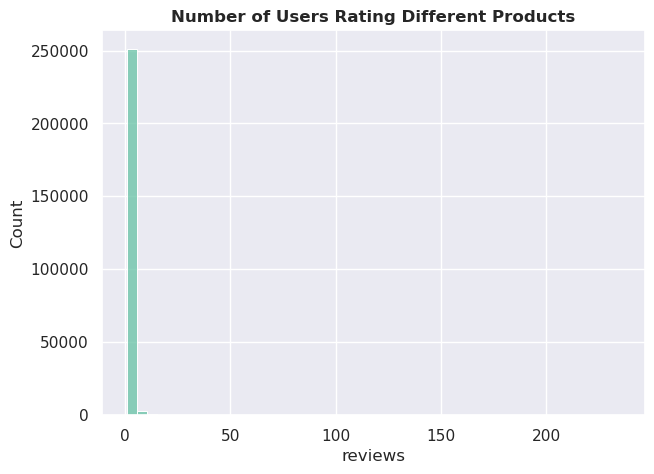

In [70]:
plt.figure(figsize=(7, 5))
sns.histplot(data=u_df, x='reviews', bins=50)
plt.title('Number of Users Rating Different Products', fontweight='bold')

Text(0.5, 1.0, 'Variation in Review Counts for Different Users')

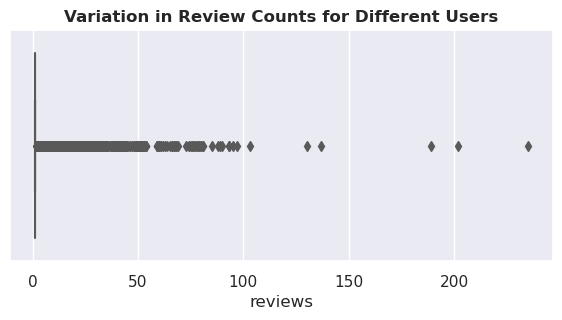

In [71]:
plt.figure(figsize=(7, 3))
sns.boxplot(data=u_df, x='reviews', orient='h')
plt.title('Variation in Review Counts for Different Users', fontweight='bold')

Text(0.5, 1.0, 'Number of Users Rating Different Products [Total Reviews < 100]')

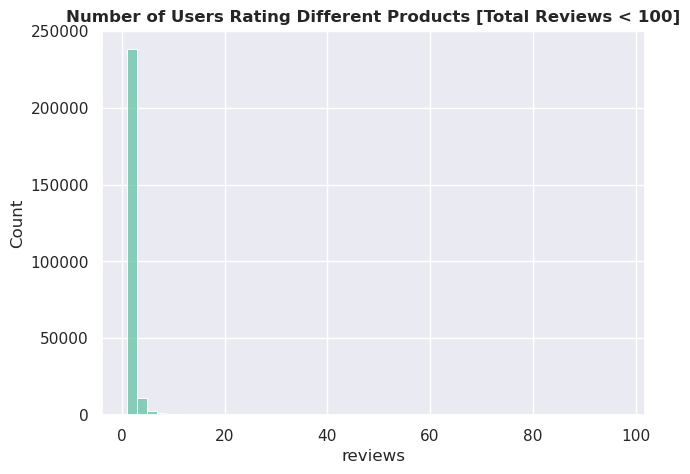

In [72]:
plt.figure(figsize=(7, 5))
sns.histplot(data=u_df[u_df['reviews'] < 100], x='reviews', bins=50)
plt.title('Number of Users Rating Different Products [Total Reviews < 100]', fontweight='bold')

Text(0.5, 1.0, 'Variation in Review Counts for Different Users [Total Reviews < 100]')

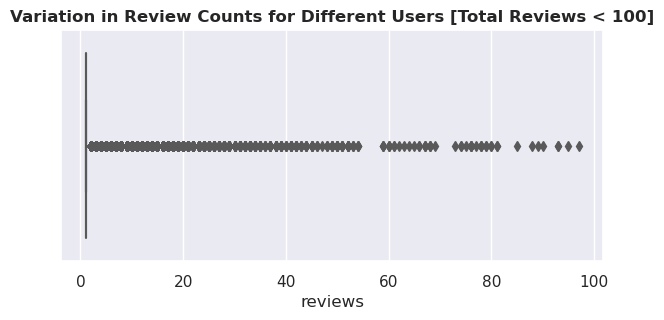

In [73]:
plt.figure(figsize=(7, 3))
sns.boxplot(data=u_df[u_df['reviews'] < 100], x='reviews', orient='h')
plt.title('Variation in Review Counts for Different Users [Total Reviews < 100]', fontweight='bold')

Text(0.5, 1.0, 'Number of Users Rating Different Products [Total Reviews < 10]')

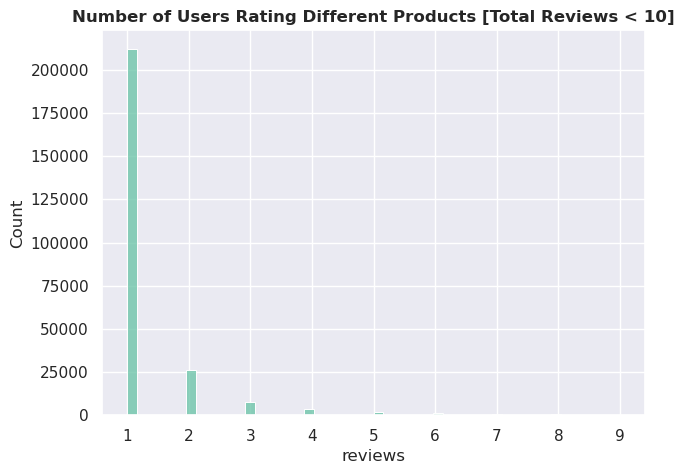

In [74]:
plt.figure(figsize=(7, 5))
sns.histplot(data=u_df[u_df['reviews'] < 10], x='reviews', bins=50)
plt.title('Number of Users Rating Different Products [Total Reviews < 10]', fontweight='bold')

Text(0.5, 1.0, 'Number of Users Rating Different Products [Total Reviews < 10]')

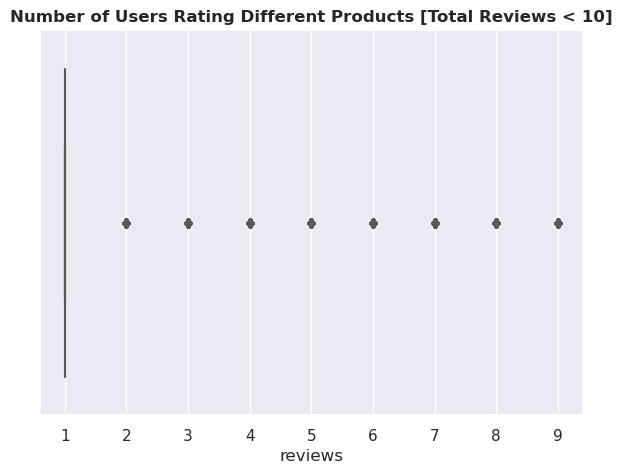

In [75]:
plt.figure(figsize=(7, 5))
sns.boxplot(data=u_df[u_df['reviews'] < 10], x='reviews')
plt.title('Number of Users Rating Different Products [Total Reviews < 10]', fontweight='bold')

We can show the drop in users reviewing more than 1, 2, 3 items, etc. using the graph below.

<Axes: title={'center': '% Users Reviewing More Than Different Numbers of Products'}, xlabel='Number of Products'>

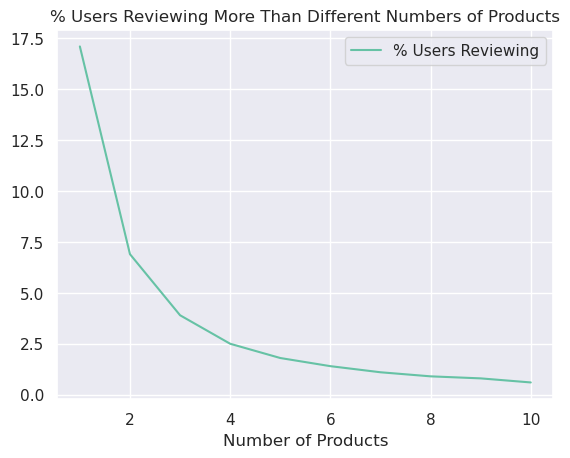

In [76]:
u_review_drop = pd.DataFrame(index=range(1, 11))
u_review_drop.index.name = 'Number of Products'

for i in range(1, 11):
    
    u_review_drop.loc[i, '% Users Reviewing'] = round((100*len(u_df[u_df['reviews'] > i]))/len(u_df), 1)
    
u_review_drop.plot(title='% Users Reviewing More Than Different Numbers of Products')

The extraordinary number of users giving just one review increases the graph scale and we lose resolution.  

We show the above plots after removing the users who have given less than 5 reviews in total.

In [77]:
u_df1 = u_df[u_df['reviews'] > 5]

Text(0.5, 1.0, 'Number of Users Rating Different Products')

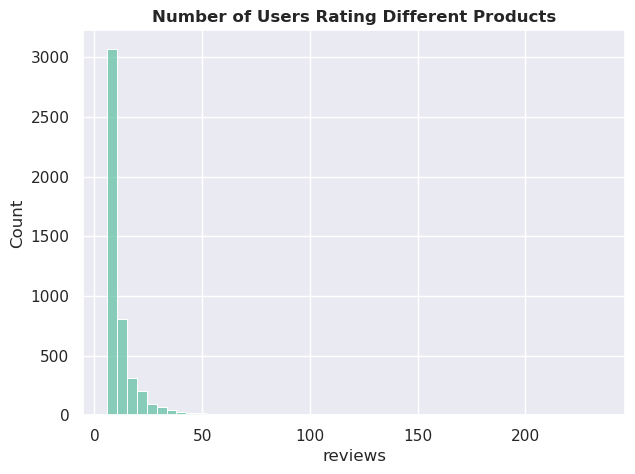

In [78]:
plt.figure(figsize=(7, 5))
sns.histplot(data=u_df1, x='reviews', bins=50)
plt.title('Number of Users Rating Different Products', fontweight='bold')

Text(0.5, 1.0, 'Variation in Review Counts for Different Users')

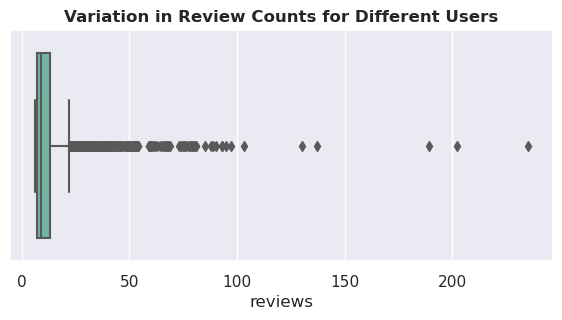

In [79]:
plt.figure(figsize=(7, 3))
sns.boxplot(data=u_df1, x='reviews', orient='h')
plt.title('Variation in Review Counts for Different Users', fontweight='bold')

Text(0.5, 1.0, 'Number of Users Rating Different Products [Total Reviews < 100]')

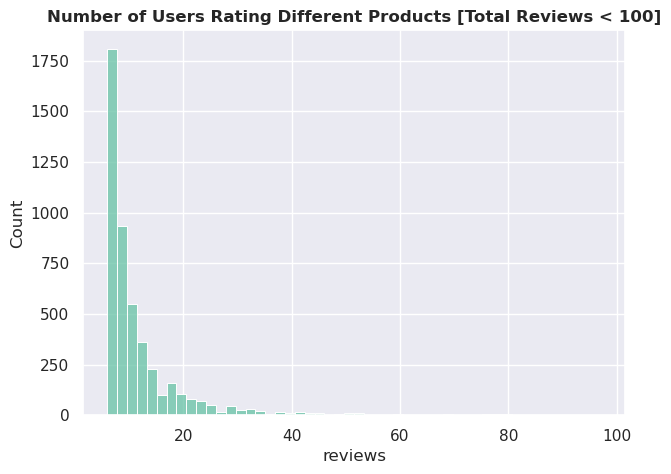

In [80]:
plt.figure(figsize=(7, 5))
sns.histplot(data=u_df1[u_df1['reviews'] < 100], x='reviews', bins=50)
plt.title('Number of Users Rating Different Products [Total Reviews < 100]', fontweight='bold')

Text(0.5, 1.0, 'Variation in Review Counts for Different Users [Total Reviews < 100]')

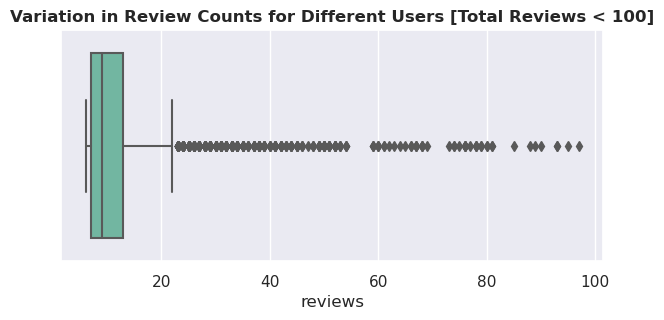

In [81]:
plt.figure(figsize=(7, 3))
sns.boxplot(data=u_df1[u_df1['reviews'] < 100], x='reviews', orient='h')
plt.title('Variation in Review Counts for Different Users [Total Reviews < 100]', fontweight='bold')

Text(0.5, 1.0, 'Number of Users Rating Different Products [Total Reviews < 10]')

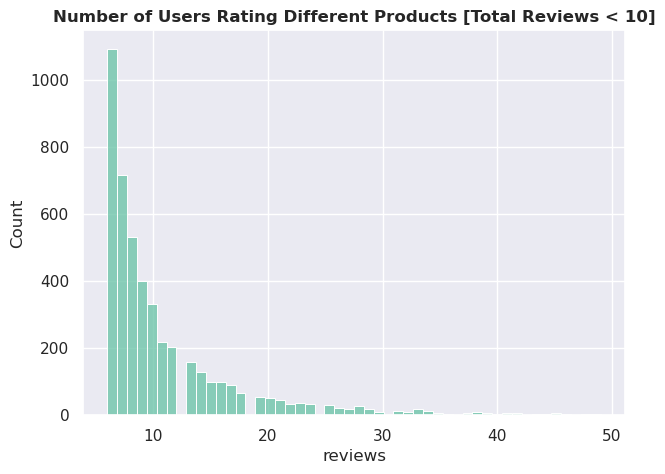

In [82]:
plt.figure(figsize=(7, 5))
sns.histplot(data=u_df1[u_df1['reviews'] < 50], x='reviews', bins=50)
plt.title('Number of Users Rating Different Products [Total Reviews < 10]', fontweight='bold')

Text(0.5, 1.0, 'Number of Users Rating Different Products [Total Reviews < 10]')

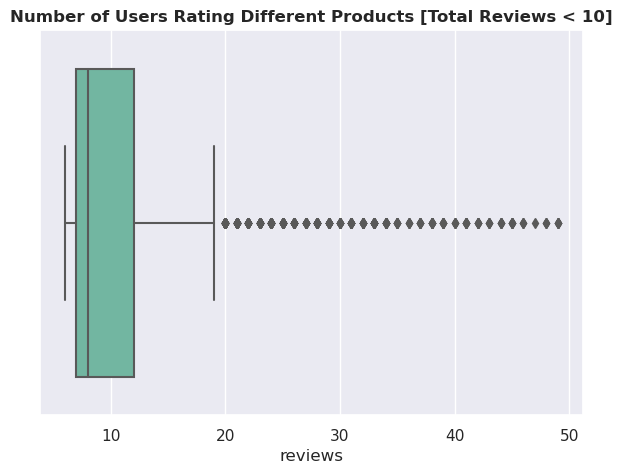

In [83]:
plt.figure(figsize=(7, 5))
sns.boxplot(data=u_df1[u_df1['reviews'] < 50], x='reviews')
plt.title('Number of Users Rating Different Products [Total Reviews < 10]', fontweight='bold')

Above plots confirm that a maximum fraction of users have given 1-20 reviews with a steady fraction of users
giving up to 235 reviews.

In [84]:
# Function to display two dataframes side-by-side

from IPython.display import display_html
from itertools import chain,cycle
def display_side_by_side(*args,titles=cycle([''])):
    html_str=''
    for df,title in zip(args, chain(titles,cycle(['</br>'])) ):
        html_str+='<th style="text-align:center"><td style="vertical-align:top">'
        html_str+=f'<h2 style="text-align: center;">{title}</h2>'
        html_str+=df.to_html().replace('table','table style="display:inline"')
        html_str+='</td></th>'
    display_html(html_str,raw=True)

Next, we find the fractions of users giving scores in different mean ranges and modes.

In [85]:
a = pd.DataFrame(u_df['mean_cat'].value_counts())
b = pd.DataFrame(u_df['mode'].value_counts())

display_side_by_side(a,b, titles=['Mean Ratings','Mode Ratings'])

,mean_cat
4-5,194390
0-1,24317
2-3,17869
1-2,11717
3-4,7766
,mode
5,163354
4,31971
1,29501
3,17200


In [86]:
u_df['mode'].value_counts()

5    163354
4     31971
1     29501
3     17200
2     14033
Name: mode, dtype: int64

Text(0.5, 1.0, '% Users with Mean Ratings in Different Ranges\n')

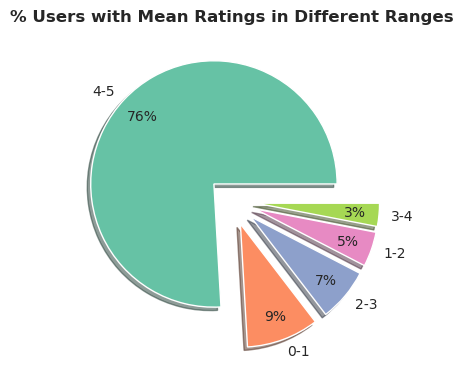

In [87]:
plt.figure(figsize=(4, 4))
plt.pie(u_df['mean_cat'].value_counts(), labels=u_df['mean_cat'].value_counts().index, autopct='%1.0f%%', pctdistance=0.8, shadow=True, explode=0.2*np.ones(5),textprops={'fontsize': 10})
plt.title('% Users with Mean Ratings in Different Ranges\n', fontweight='bold', fontsize=12)

Text(0.5, 1.0, '% Users with Different Mode Ratings\n')

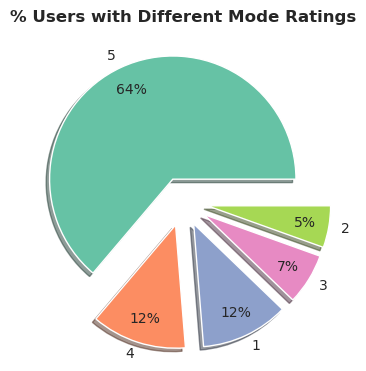

In [88]:
plt.figure(figsize=(4, 4))
plt.pie(u_df['mode'].value_counts(), labels=u_df['mode'].value_counts().index, autopct='%1.0f%%', pctdistance=0.8, shadow=True, explode=0.2*np.ones(5),textprops={'fontsize': 10})
plt.title('% Users with Different Mode Ratings\n', fontweight='bold', fontsize=12)

We note that most reviews given include a score of 5.

In [89]:
u_df[['mean', 'reviews']].sort_values(['mean', 'reviews'], ascending=[False, False]).head(10)

,mean,reviews
uid,,
A31J176KH7ZZEY,5.0,24
A3F1G6UH4Y39X2,5.0,23
A1VBDMNT6I8RE5,5.0,21
A2YO8731SKDKLL,5.0,20
A29P51TN9KKMU9,5.0,20
A11WYHDB1YEZOX,5.0,19
A2DOQ9ERI5ELAZ,5.0,18
AA4GC72H2UZQ4,5.0,18
A2NI95Y8UNE85D,5.0,16


Based on reviews given by users, we can classify them as,  

a. **Engaged and satisfied**: Large review counts, High mean scores  
b. **Engaged and dissatisfied**: Large review counts, Low mean scores  
c. **Unengaged and satisfied**: Small review counts, High mean scores  
d. **Unengaged and dissatisfied**: Small review counts, Low mean scores  

The lists for users of the first two types are shown below.

In [90]:
a = u_df[(u_df['reviews']>50) & (u_df['mean']>4)][['mean', 'reviews']].sort_values(['mean', 'reviews'], ascending=[False, False]).head(10).style.set_caption('Top Engaged and Satisfied Users: Reviews > 50, Mean Score > 4]')
b = u_df[(u_df['reviews']>50) & (u_df['mean']<3.5)][['mean', 'reviews']].sort_values(['mean', 'reviews'], ascending=[False, False]).head(10).style.set_caption('Top Engaged but Dissatisfied Users: Reviews > 50, Mean Score < 3.5]')
display_side_by_side(a,b)

,mean,reviews
uid,,
A1LZJZIHUPLDV4,4.930000,75
AZV26LP92E6WU,4.710000,76
A281NPSIMI1C2R,4.660000,189
A2E3WMF9RWW2X2,4.640000,52
A2MNB77YGJ3CN0,4.620000,66
A1080SE9X3ECK0,4.620000,61
A2R6RA8FRBS608,4.610000,93
ACYR6O588USK,4.590000,53
A1ZH9LWMX5UCFJ,4.550000,68


While there are quite a few instances for **engaged, satisfied** users, there are very few instances for **engaged, dissatisfied** users.   

This suggests, most users who have reviewed extensively have overall liked the items they reviewed.  

The lists for satisfied and dissatisfied users among those with limited reviews (10-50) are shown below.

In [91]:
a = u_df[(u_df['reviews']>10) & (u_df['reviews']<50) & 
     (u_df['mean']>4)][['mean', 'reviews']].sort_values(['mean', 'reviews'], 
                                                        ascending=[False, False]).head(10).style.set_caption(
    'Limited Engagement and High Satisfaction: 10 < Reviews < 50, Mean Score > 4]')

b = u_df[(u_df['reviews']>10) & (u_df['reviews']<50) & 
     (u_df['mean']<3)][['mean', 'reviews']].sort_values(['mean', 'reviews'], 
                                                        ascending=[True, False]).head(10).style.set_caption(
    'Limited Engagement and Low Satisfaction: 10 < Reviews < 50, Mean Score < 3]')

display_side_by_side(a,b)

,mean,reviews
uid,,
A31J176KH7ZZEY,5.000000,24
A3F1G6UH4Y39X2,5.000000,23
A1VBDMNT6I8RE5,5.000000,21
A2YO8731SKDKLL,5.000000,20
A29P51TN9KKMU9,5.000000,20
A11WYHDB1YEZOX,5.000000,19
A2DOQ9ERI5ELAZ,5.000000,18
AA4GC72H2UZQ4,5.000000,18
A2NI95Y8UNE85D,5.000000,16


In [92]:
a = u_df[(u_df['reviews']>1) & (u_df['reviews']<10) & 
     (u_df['mean']>4)][['mean', 'reviews']].sort_values(['mean', 'reviews'], 
                                                        ascending=[False, False]).head(10).style.set_caption(
    'Low Engagement and High Satisfaction: 1 < Reviews < 10, Mean Score > 4]')

b = u_df[(u_df['reviews']>1) & (u_df['reviews']<10) & 
     (u_df['mean']<3)][['mean', 'reviews']].sort_values(['mean', 'reviews'], 
                                                        ascending=[True, False]).head(10).style.set_caption(
    'Low Engagement and Low Satisfaction: 1 < Reviews < 10, Mean Score < 3]')

display_side_by_side(a,b)

,mean,reviews
uid,,
A3977OZLNA8LCB,5.000000,9
A27DDHWHE540I5,5.000000,9
A3Q52B7U4RGX0O,5.000000,9
A1L6Q8E1PNMN2G,5.000000,9
A2AM4UJIK0YDUO,5.000000,9
A34HIENNTM60TS,5.000000,9
AGJRZA4GW3E1H,5.000000,9
A220D2275RR2EB,5.000000,9
A3SQQYS79AV13M,5.000000,9


In [93]:
len(u_df[(u_df['reviews']>1) & (u_df['reviews']<10) & 
     (u_df['mean']>4)][['mean', 'reviews']].sort_values(['mean', 'reviews'], 
                                                        ascending=[False, False]))

24240

In [94]:
len(u_df[(u_df['reviews']>1) & (u_df['reviews']<10) & 
     (u_df['mean']<3)][['mean', 'reviews']].sort_values(['mean', 'reviews'], 
                                                        ascending=[True, False]))

3678

Overall, we find 24240 low-reviewing users satisfied but 3678 such users dissatisfied.   

This indicates a significant fraction of low-reviewing users appear satisfied.   
Still, the number of dissatisfied users is too significant to ignore.

In [95]:
u_df[u_df['reviews']>100].style.background_gradient()

,reviews,1,2,3,4,5,mean,mode,mean_cat,1+2,4+5
uid,,,,,,,,,,,
AY12DBB0U420B,235,0,2,6,21,69,4.510000,5,4-5,2,90
A3OXHLG6DIBRW8,202,0,1,4,34,59,4.450000,5,4-5,1,93
A281NPSIMI1C2R,189,0,0,8,8,82,4.660000,5,4-5,0,90
A1Z54EM24Y40LL,137,2,6,14,20,55,4.110000,5,4-5,8,75
A2MUGFV2TDQ47K,130,6,16,16,24,36,3.620000,5,3-4,22,60
A1WX42M589VAMQ,103,8,6,8,22,53,3.970000,5,3-4,14,75


For a closer analysis, at both item and user levels, we can show distributions of scores as below.

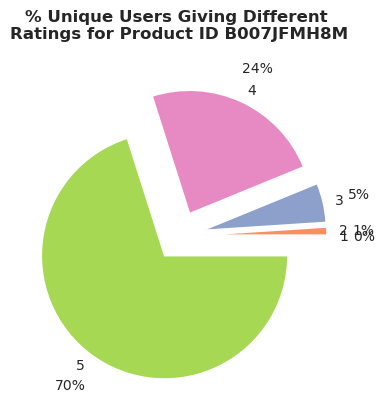

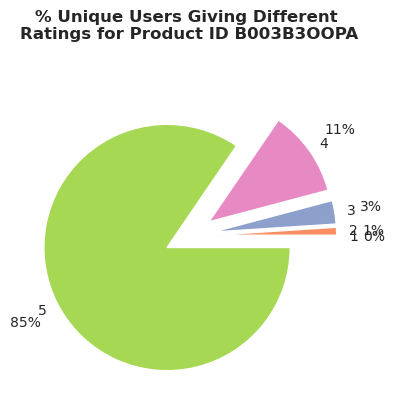

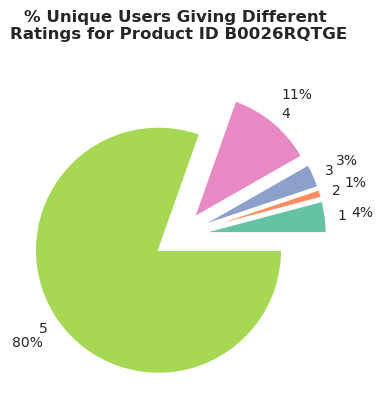

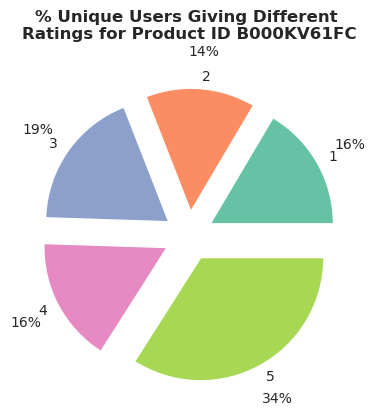

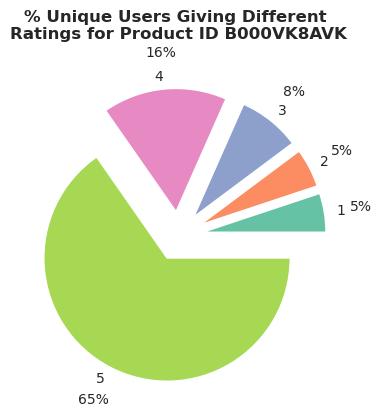

In [96]:
for idx in range(5):
    
    plt.figure(figsize=(4, 4))
    plt.pie(p_df.iloc[idx, 1:6], labels=p_df.iloc[idx, 1:6].index, autopct='%1.0f%%', pctdistance=1.3, explode=0.2*np.ones(5),textprops={'fontsize': 10})
    plt.title('% Unique Users Giving Different \nRatings for Product ID ' + p_df.index[idx] + '\n\n', fontweight='bold', fontsize=12)

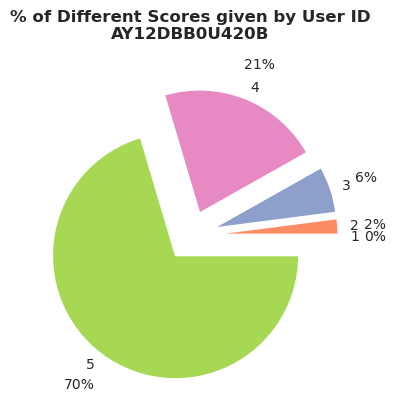

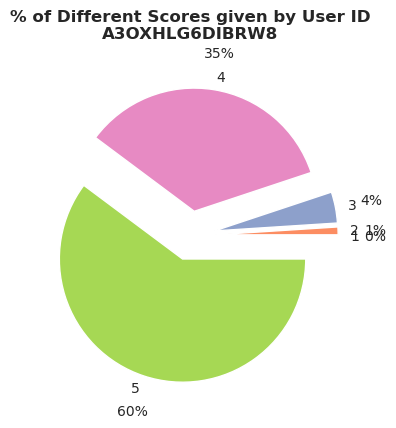

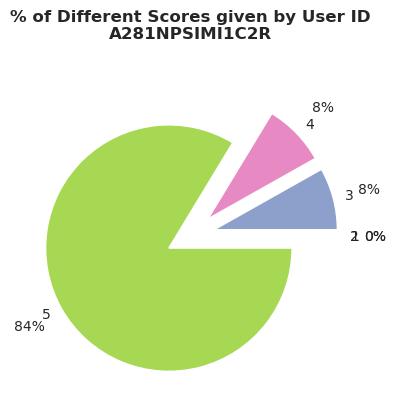

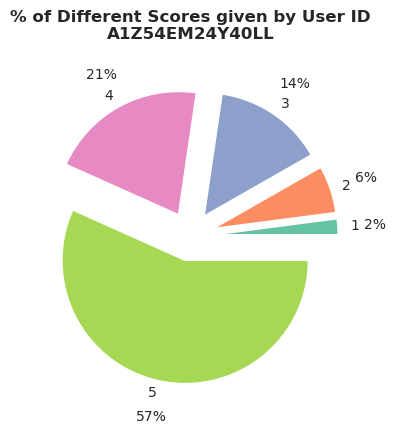

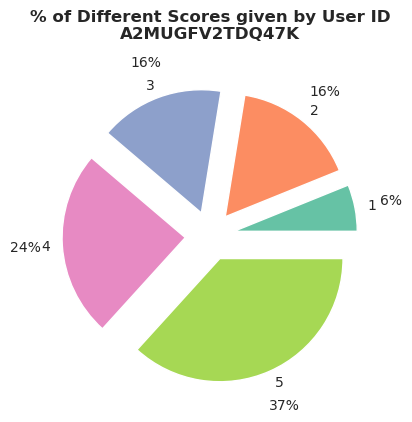

In [97]:
for idx in range(5):
    
    plt.figure(figsize=(4, 4))
    plt.pie(u_df.iloc[idx, 1:6], labels=u_df.iloc[idx, 1:6].index, autopct='%1.0f%%', pctdistance=1.3, explode=0.2*np.ones(5),textprops={'fontsize': 10})
    plt.title('% of Different Scores given by User ID\n' + u_df.index[idx] + '\n\n', fontweight='bold', fontsize=12)

Next, we move to a short analysis of sentiments expressed in the text reviews and classification of products and
items on its basis.

Now, we focus on the text reviews given for each user-product pair at the same or different times. We find
duplicate text entries with,

a. **Different users, same product, same text review, same time**  
b. **Different users, same product, same text review, different times**  
c. **Different users, different products, same text review, same time**  
d. **Different users, different products, same text review, different times**  

In [98]:
df1 = df[['pid', 'uid', 'text', 'time']]
df1.drop_duplicates(inplace=True)
df1.drop_duplicates(['pid', 'uid'], keep='last', inplace=True)
df1.drop_duplicates(['text'], inplace=True)

In [99]:
df1.head()

,pid,uid,text,time
515425,141278509X,AB1A5EGHHVA9M,This product by Archer Farms is the best drink...,1332547200
24749,2734888454,A13ISQV0U9GZIC,My dogs loves this chicken but its a product f...,1192060800
24750,2734888454,A1C298ITT645B6,Our dogs just love them. I saw them in a pet ...,1195948800
308076,2841233731,A3QD68O22M2XHQ,This book is easy to read and the ingredients ...,1345852800
150518,6641040,A12HY5OZ2QNK4N,I've always loved chicken soup and rice. My la...,1256774400


We confirm below that each text and user entries are unique both independently and together.

In [100]:
pdf_count = df1.pivot_table(index='pid', values=['uid', 'text'], aggfunc=lambda x: len(x.unique())).sort_values('uid', ascending=False)
pdf_count.rename({'text': 'unique_count(text)', 'uid': 'unique_count(uid)'}, inplace=True)

pdf_count1 = df1.pivot_table(index='pid', values=['uid', 'text'], aggfunc='count').sort_values('uid', ascending=False)
pdf_count1.rename({'text': 'count(text)', 'uid': 'count(uid)'}, inplace=True)

In [101]:
display_side_by_side(pdf_count1.head(), pdf_count.head(), titles=['Counts', 'Unique Counts'])

,text,uid
pid,,
B007JFMH8M,909,909
B003B3OOPA,623,623
B0026RQTGE,609,609
B001EO5Q64,565,565
B000KV61FC,555,555
,text,uid
pid,,
B007JFMH8M,909,909
B003B3OOPA,623,623


Deeper text analysis typically requires these steps:  

a. Removal of punctuations, upper cases  
b. **Tokenization**: Breaking down text into smaller labeled units (word/sentence levels commonly)  
c. Removal of stop words (common words which do not give extra information)  
d. **Stemming**: A dirty removal of last few characters to reduce words to root or base form (leads to meaning-less words)  
e. **Lemmatization**: A slower, corpus-informed approach to reduce words to roots or base forms  
f. (Optional): Spell-correct, removing private information/url/tags/special characters or terms, etc.  

However, we do not perform these at this point, trusting the sentiment analysis libraries to take care of these.

### Sentiment Analysis
  
  
**Sentiment Analysis** is an application of **Natural Language Processing** techniques to infer if a text contains a positive or a negative sentiment.  

It can be done at different levels: *sentences* or *documents*.   
It can also involve inferring sentiments towards a specific *aspect’ of a product or towards any particular entity.*  

We currently perform a sentiment analysis of review texts using 2 NLP libraries: **TextBlob** and **Vader**.

#### Sentiment Scores using TextBlob  

We can provide our review texts as inputs to TextBlob and obtain 2 scores:  

**Subjectivity**: A number between 0 (pure fact) and 1 (pure opinion).  

**Polarity**: A number between -1 (highly negative sentiment) and 1 (highly positive sentiment) with 0 as neutral  

For each review comment across all products, we first get the above scores, encode it and finally find frequency
%ages of each sentiment code.  

We encode **subjectivity** scores as,  

**low**: Less than 0.33    
**medium**: 0.33 to 0.66      
**high**: More than 0.66    

And **polarity** scores as,  

**very negative**: -1 to -0.5  
**negative**: -0.5 to 0    
**neutral**: 0  
**positive**: 0 to 0.5  
**very positive**: 0.5 to 1   

We finally create 15 custom scores (3 x 5) combining both the above scores. These are encoded as low_very_negative, medium positive, high_very_positive, etc.

In [102]:
ps1 = random.sample(pdf_count[pdf_count['text']<10].index.tolist(), 2)
ps2 = random.sample(pdf_count[(pdf_count['text']>=10) & (pdf_count['text']<200)].index.tolist(), 2)
ps3 = random.sample(pdf_count[(pdf_count['text']>=200) & (pdf_count['text']<500)].index.tolist(), 2)
ps4 = random.sample(pdf_count[(pdf_count['text']>=500) & (pdf_count['text']<1000)].index.tolist(), 2)

ps = ps1 + ps2 + ps3 + ps4

In [103]:
def pdf(idx):
    
    return df1[df1['pid']==idx][['pid', 'uid', 'text']]

In [104]:
def get_pol(txt):
    
    blob = TextBlob(txt)
    return blob.sentiment[0]

In [105]:
def get_sub(txt):
    
    blob = TextBlob(txt)
    return blob.sentiment[1]

In [106]:
def encode_sub(x):
    
    if x<=0.33:        
        return 'low'
    
    elif (x>0.33) & (x<=0.66):        
        return 'med'
    
    elif x>0.66:        
        return 'high'

In [107]:
def encode_pol(x):
    
    if x>0.5:        
        return 'v_pos'
    
    elif (x>0) & (x<=0.5):        
        return 'pos'
    
    if x==0:        
        return 'neu'
    
    elif (x>-0.5) & (x<=0):        
        return 'neg'
    
    elif x<=-0.5:        
        return 'v_neg'

In [108]:
p_all = df1[['pid', 'uid', 'text']]
p_all['sub'] = p_all['text'].apply(get_sub)
p_all['pol'] = p_all['text'].apply(get_pol)

p_all['sub_type'] = p_all['sub'].apply(encode_sub)
p_all['pol_type'] = p_all['pol'].apply(encode_pol)
p_all['sub_pol'] = p_all['sub_type'] + '_' + p_all['pol_type']

In [109]:
p_all['sub_type'] = p_all['sub'].apply(encode_sub)
p_all['pol_type'] = p_all['pol'].apply(encode_pol)
p_all['sub_pol'] = p_all['sub_type'] + '_' + p_all['pol_type']

The first few rows of the resulting table is shown below.

In [110]:
p_all.head()

,pid,uid,text,sub,pol,sub_type,pol_type,sub_pol
515425,141278509X,AB1A5EGHHVA9M,This product by Archer Farms is the best drink...,0.521429,0.344898,med,pos,med_pos
24749,2734888454,A13ISQV0U9GZIC,My dogs loves this chicken but its a product f...,0.774167,-0.315833,high,neg,high_neg
24750,2734888454,A1C298ITT645B6,Our dogs just love them. I saw them in a pet ...,0.700000,0.500000,high,pos,high_pos
308076,2841233731,A3QD68O22M2XHQ,This book is easy to read and the ingredients ...,0.694345,0.373810,high,pos,high_pos
150518,6641040,A12HY5OZ2QNK4N,I've always loved chicken soup and rice. My la...,0.685897,-0.096154,high,neg,high_neg


We find that most reviews have a medium subjectivity.

Text(0.5, 1.0, 'Distribution of Subjectivity in Reviews (Overall)')

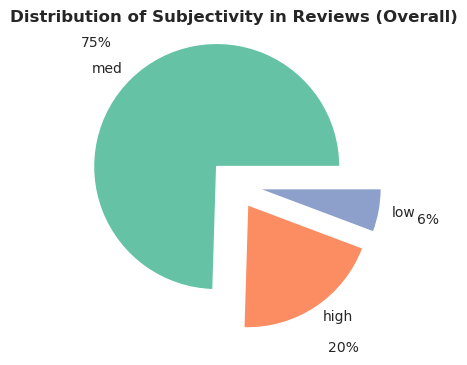

In [111]:
sub_freq = p_all['sub_type'].value_counts()

plt.figure(figsize=(4, 4))
plt.pie(sub_freq, labels=sub_freq.index, autopct='%1.0f%%', pctdistance=1.4, explode=0.2*np.ones(len(sub_freq)),textprops={'fontsize': 10})
plt.title('Distribution of Subjectivity in Reviews (Overall)', fontweight='bold', fontsize=12)

Text(0.5, 1.0, 'Distribution of Polarity in Reviews (Overall)')

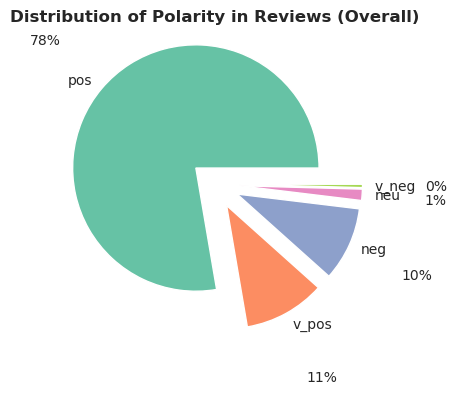

In [112]:
pol_freq = p_all['pol_type'].value_counts()

plt.figure(figsize=(4, 4))
plt.pie(pol_freq, labels=pol_freq.index, autopct='%1.0f%%', pctdistance=1.6, explode=0.2*np.ones(len(pol_freq)),textprops={'fontsize': 10})
plt.title('Distribution of Polarity in Reviews (Overall)', fontweight='bold', fontsize=12)

Text(0.5, 1.0, 'Distribution of Subjectivity and Polarity in Reviews (Overall)')

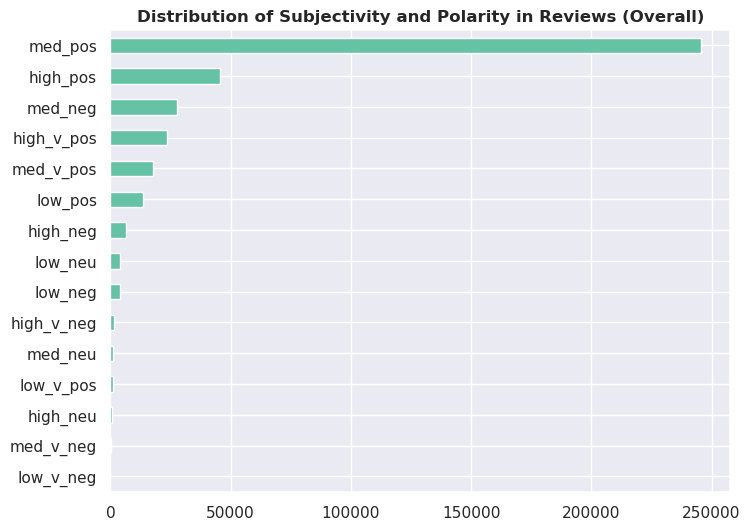

In [113]:
sub_pol_freq = p_all['sub_pol'].value_counts()

plt.figure(figsize=(8, 6))
sub_pol_freq.sort_values().plot(kind='barh')
plt.title('Distribution of Subjectivity and Polarity in Reviews (Overall)', fontweight='bold', fontsize=12)

* Low subjectivity can be desirable for us, but only 6% of the comments have low subjectivity. A significant 20% of comments are highly subjective.  

* 78% reviews are positive and 11% are highly positive. Extremely tiny fraction of reviews have a very negative
sentiment. This is an encouraging fact.  

* A significant 10% reviews have a negative sentiment which could be looked at more closely to probe causes.  

* For most products, medium subjectivity was observed most frequently among comments.  

* 16% products with highly subjective reviews can also be interesting to explore further.  

* For 83% products, the most commonly observed sentiment was positive, and for 8%, very positive.  

Ideally, it would be encouraging to see factual, very positive reviews. Next we show the distribution of our
custom metric combining subjectivity and polarity across all product reviews.

In [114]:
pdict = {}

for idx in ps:
    
    pdict[idx] = pdf(idx)

    pdict[idx]['sub'] = pdict[idx]['text'].apply(get_sub)
    pdict[idx]['pol'] = pdict[idx]['text'].apply(get_pol)
    pdict[idx]['sub_type'] = pdict[idx]['sub'].apply(encode_sub)
    pdict[idx]['pol_type'] = pdict[idx]['pol'].apply(encode_pol)
    pdict[idx]['sub_pol'] = pdict[idx]['sub_type'] + '_' + pdict[idx]['pol_type']
    pdict[idx] = pdict[idx].sort_values(['sub', 'pol'], ascending=[True, False])

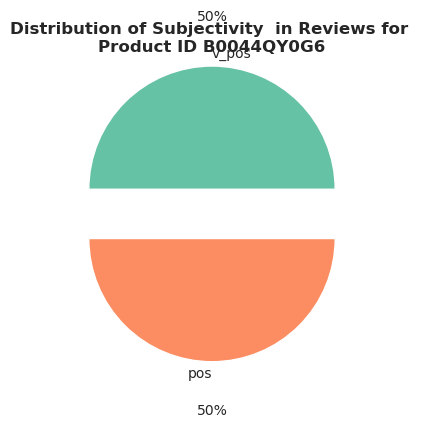

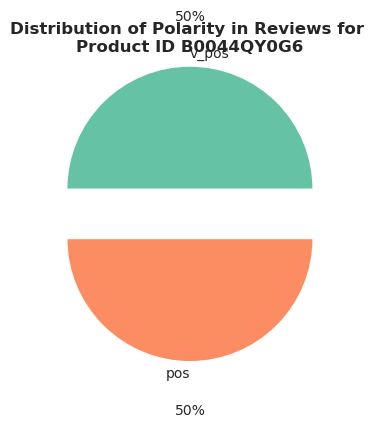

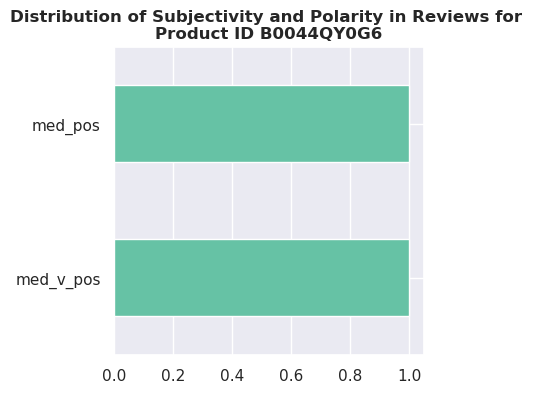

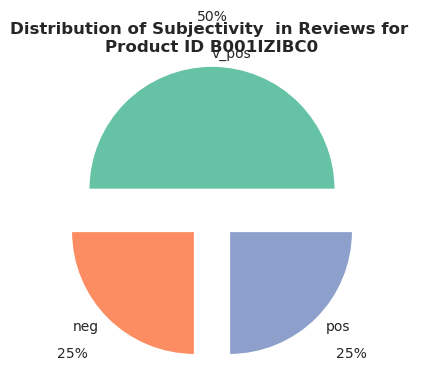

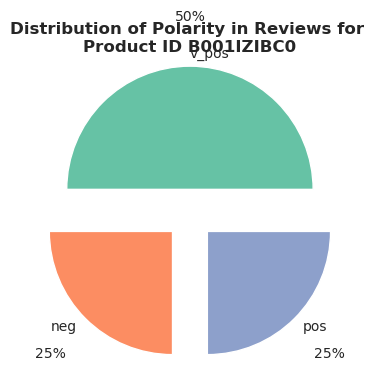

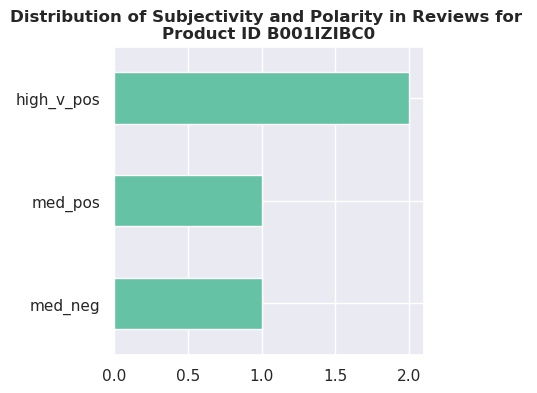

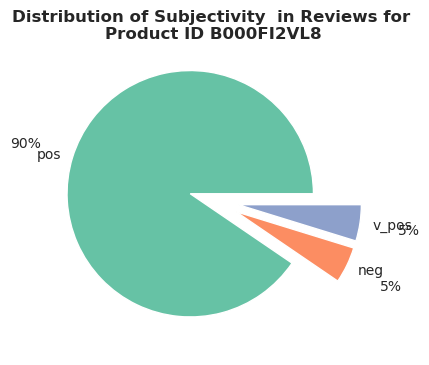

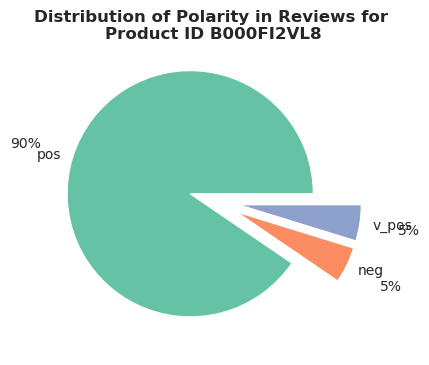

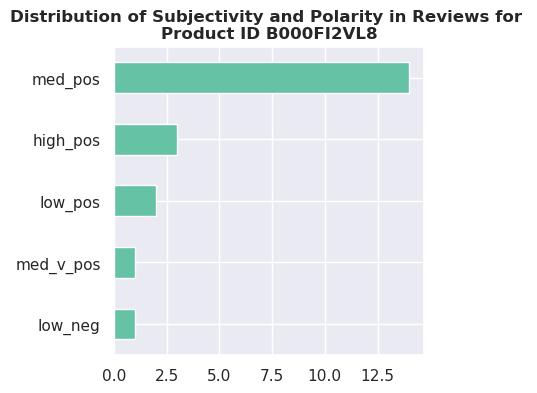

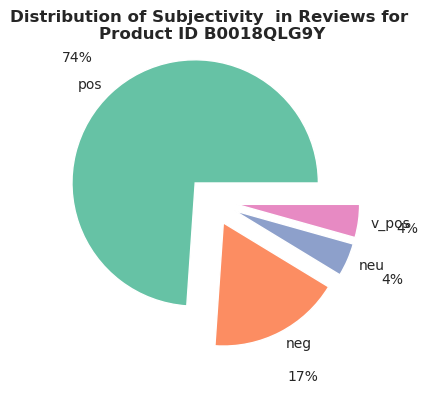

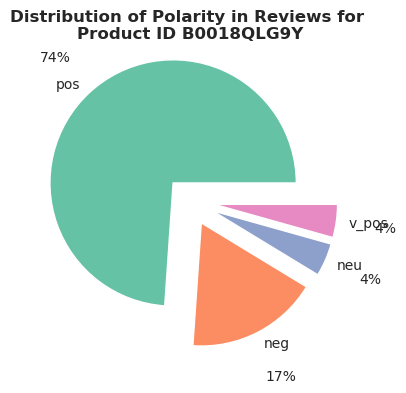

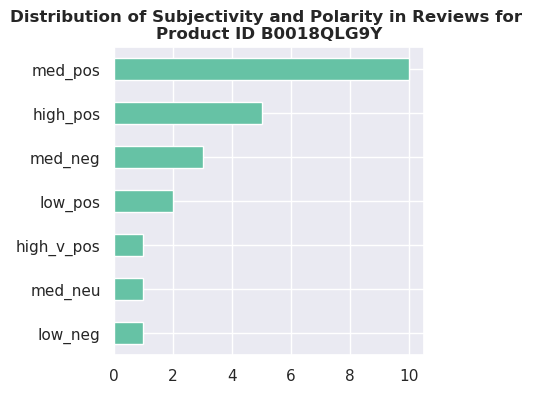

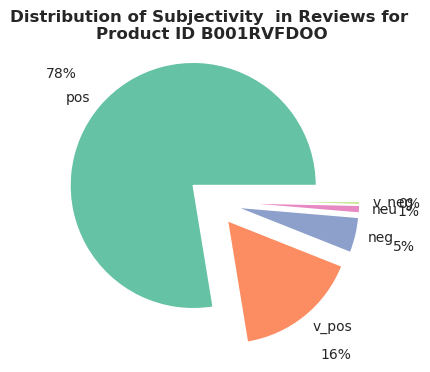

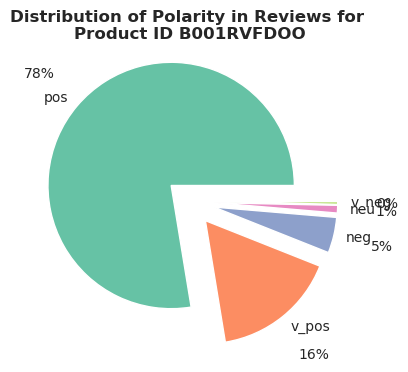

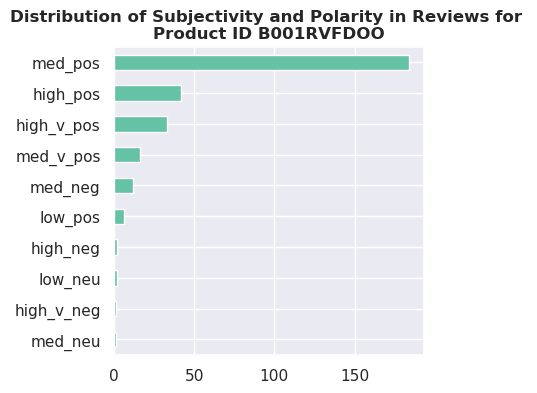

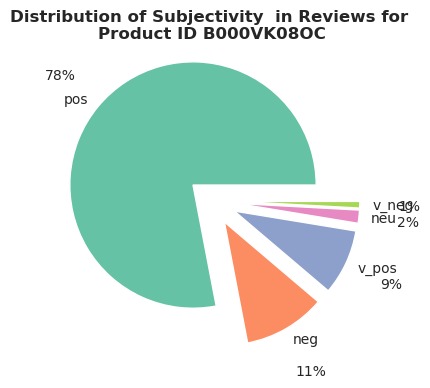

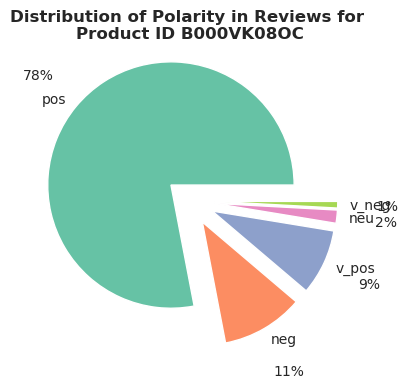

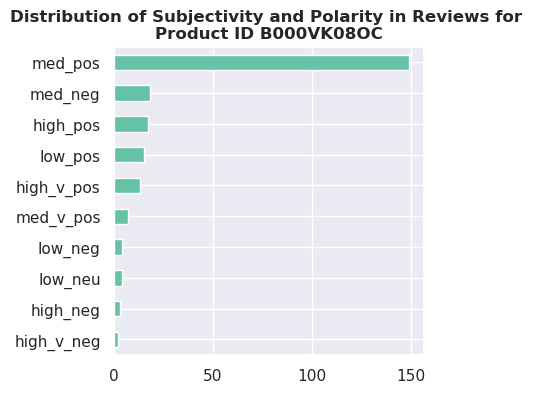

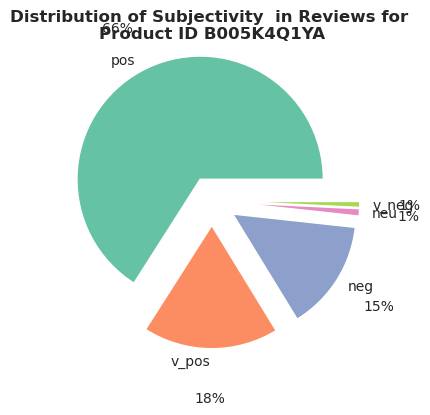

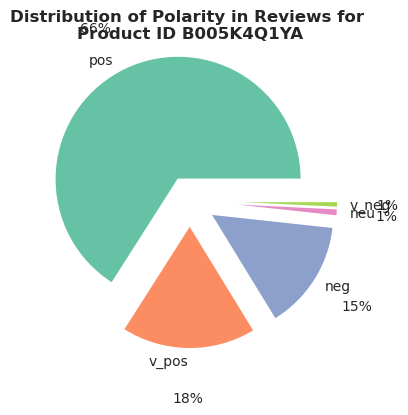

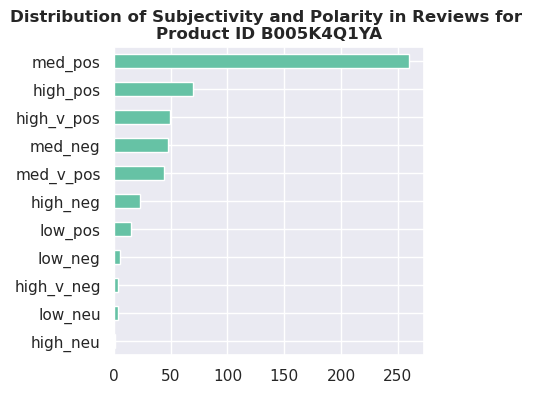

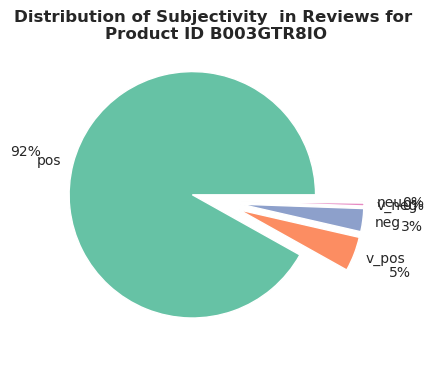

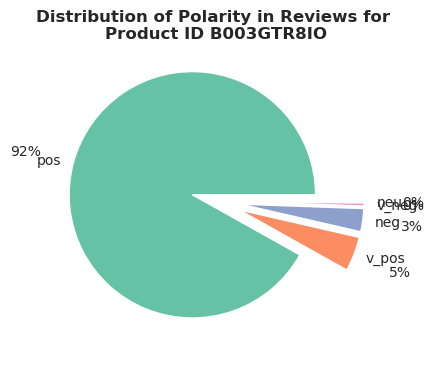

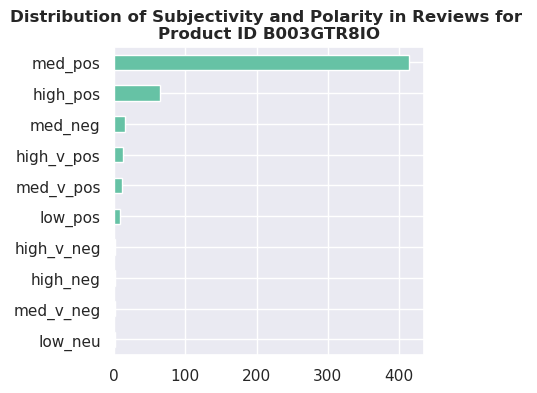

In [115]:
for idx in ps:
    
    sub_freq = pdict[idx]['pol_type'].value_counts()
    pol_freq = pdict[idx]['pol_type'].value_counts()    
    sub_pol_freq = pdict[idx]['sub_pol'].value_counts()
    
    
    plt.figure(figsize=(4, 4))
    plt.pie(sub_freq, labels=sub_freq.index, autopct='%1.0f%%', pctdistance=1.4, explode=0.2*np.ones(len(sub_freq)),textprops={'fontsize': 10})
    plt.title('Distribution of Subjectivity  in Reviews for \nProduct ID ' + str(idx), fontweight='bold', fontsize=12)
    
    plt.figure(figsize=(4, 4))
    plt.pie(pol_freq, labels=pol_freq.index, autopct='%1.0f%%', pctdistance=1.4, explode=0.2*np.ones(len(pol_freq)),textprops={'fontsize': 10})
    plt.title('Distribution of Polarity in Reviews for \nProduct ID ' + str(idx), fontweight='bold', fontsize=12)
    
    plt.figure(figsize=(4, 4))
    sub_pol_freq.sort_values().plot(kind='barh')   
    plt.title('Distribution of Subjectivity and Polarity in Reviews for \nProduct ID ' + str(idx), fontweight='bold', fontsize=12)

We observe,  

* Most reviews are positive but are medium-subjective.  

* A significant fraction of reviews are positive but highly subjective.  

* A good fraction of reviews with low subjectivity are positive (shown as ‘low_pos’).  

* The considerable fraction of reviews with low subjectivity and negative sentiment (‘low_neg’) can help us probe deeper into issues with these items.   

* A considerable fraction of negative reviews are highly subjective (‘high_neg’).  

We can perform a similar classification at the item level.   
Below we classify review sentiments for a sample of items taken from different review count ranges (<10, 10-200, 200-500, 500-1000).

In [116]:
sub_list, pol_list, sub_pol_list = [], [], []

for idx in pdf_count.index:
    
    sub_list.append(p_all[p_all['pid']==idx]['sub_type'].value_counts().index[0])
    pol_list.append(p_all[p_all['pid']==idx]['pol_type'].value_counts().index[0])
    sub_pol_list.append(p_all[p_all['pid']==idx]['sub_pol'].value_counts().index[0])
    
pdf_count['sub_type'] = sub_list
pdf_count['pol_type'] = pol_list
pdf_count['sub_pol'] = sub_pol_list

Text(0.5, 1.0, 'Distribution of Subjectivity and Polarity across Products')

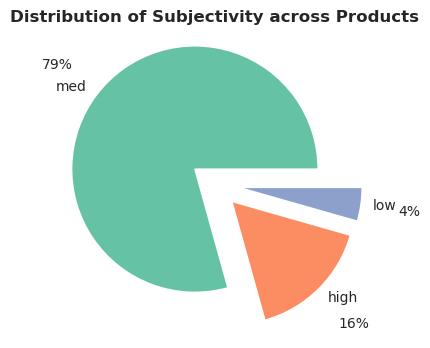

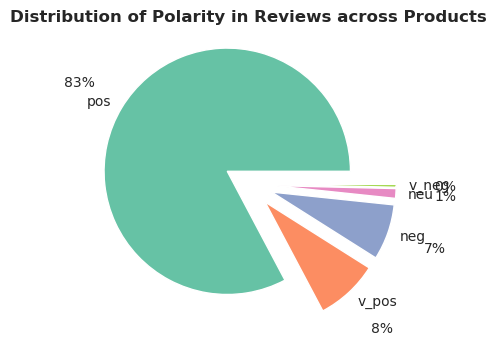

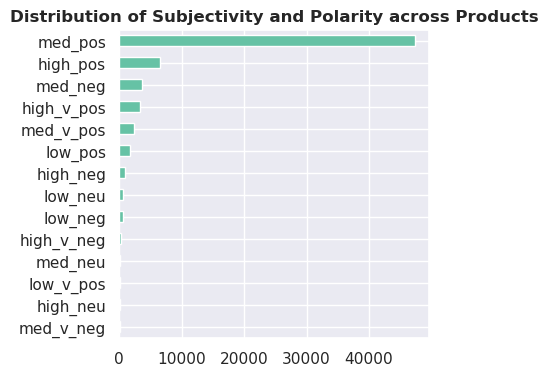

In [117]:
sub_freq = pdf_count['sub_type'].value_counts()
pol_freq = pdf_count['pol_type'].value_counts()    
sub_pol_freq = pdf_count['sub_pol'].value_counts()


plt.figure(figsize=(4, 4))
plt.pie(sub_freq, labels=sub_freq.index, autopct='%1.0f%%', pctdistance=1.4, explode=0.2*np.ones(len(sub_freq)),textprops={'fontsize': 10})
plt.title('Distribution of Subjectivity across Products', fontweight='bold', fontsize=12)

plt.figure(figsize=(4, 4))
plt.pie(pol_freq, labels=pol_freq.index, autopct='%1.0f%%', pctdistance=1.4, explode=0.2*np.ones(len(pol_freq)),textprops={'fontsize': 10})
plt.title('Distribution of Polarity in Reviews across Products', fontweight='bold', fontsize=12)

plt.figure(figsize=(4, 4))
sub_pol_freq.sort_values().plot(kind='barh')   
plt.title('Distribution of Subjectivity and Polarity across Products', fontweight='bold', fontsize=12)

For each product, we can find the dominant subjectivity and polarity scores across all its text reviews.  

This can be done by creating a frequency table of all score categories (low/medium/high, verypositive/positive/neutral/negative/very negative), sort in descending order and pick the first score category with maximum frequency.  

We obtain a table as below.

In [118]:
pdf_count.iloc[:, 2:]

,sub_type,pol_type,sub_pol
pid,,,
B007JFMH8M,med,pos,med_pos
B003B3OOPA,med,pos,med_pos
B0026RQTGE,med,pos,med_pos
B001EO5Q64,med,pos,med_pos
B000KV61FC,med,pos,med_pos
...,...,...,...
B0027UYD5O,high,pos,high_pos
B0027U8RHO,high,v_pos,high_v_pos
B0027SK9CC,med,pos,med_pos


Earlier we had shown distribution of subjectivity/polarity across all review comments at overall and product
levels. Now, we can show the fraction of total products receiving most reviews of a specific type.
We find that for only 4% of total products, the most frequent subjectivity score was low.

For most products, medium subjectivity was observed most frequently among comments. 16% products with
highly subjective reviews can also be interesting to explore further.
We find that for 83% products, the most commonly observed sentiment was positive, and for 8%, very positive.

While very few products received extreme negative reviews, a 7% significant fraction of them did receive
negative reviews.
Below, we show the distribution of our combined custom score across all products.

For deeper analysis, we can get product ids of items for different dominant score types (e.g. high subjectivity,
very negative polarity, low subjectivity + very positive polarity, etc.)
Such examples are shown below.

In [119]:
pdf_count[pdf_count['sub_type']=='low'].index[:10]

Index(['B000BO73TQ', 'B001M074LK', 'B0008309SW', 'B000E672C4', 'B001G604XU',
       'B000F4BCS0', 'B001FA1F5I', 'B0000BXJIO', 'B003W6496A', 'B0002HLGGI'],
      dtype='object', name='pid')

In [120]:
pdf_count[pdf_count['sub_type']=='high'].index[:10]

Index(['B000E671Z2', 'B002E0UEBE', 'B00164YEJ2', 'B000CMF1A0', 'B001P75CKK',
       'B0000DK4ZR', 'B002ODE1PQ', 'B0005XO85A', 'B0009ET7TC', 'B0068RFY4Q'],
      dtype='object', name='pid')

In [121]:
pdf_count[pdf_count['pol_type']=='pos'].index[:10]

Index(['B007JFMH8M', 'B003B3OOPA', 'B0026RQTGE', 'B001EO5Q64', 'B000KV61FC',
       'B000VK8AVK', 'B000NMJWZO', 'B003GTR8IO', 'B005K4Q1YA', 'B000UBD88A'],
      dtype='object', name='pid')

In [122]:
pdf_count[pdf_count['pol_type']=='v_pos'].index[:10]

Index(['B002KB2ASM', 'B0068RFY4Q', 'B000QV0M2E', 'B0047CKHO6', 'B004DJCPR0',
       'B00765PU2K', 'B0007R4JGM', 'B00115X9Q0', 'B0009F3SAA', 'B0001W2Z00'],
      dtype='object', name='pid')

In [123]:
pdf_count[pdf_count['pol_type']=='neg'].index[:10]

Index(['B004H3N2LU', 'B001C15JCU', 'B004Z33GI6', 'B000MICPUI', 'B0007DGQAI',
       'B00346J8BO', 'B000UJTZ8O', 'B000G1EO14', 'B000HHM5T0', 'B001E96JY2'],
      dtype='object', name='pid')

In [124]:
pdf_count[pdf_count['pol_type']=='v_neg'].index[:10]

Index(['B000MBKJP8', 'B003O5RW68', 'B0025Z0RRE', 'B000CDP2XA', 'B003X0VOW2',
       'B005AO13NE', 'B00473QUTG', 'B004RZZM20', 'B0027JAO26', 'B001E5DQLK'],
      dtype='object', name='pid')

In [125]:
pdf_count[pdf_count['sub_pol']=='low_v_pos'].index[:10]

Index(['B000IZPWH8', 'B004ZIF17K', 'B001KUOFZ0', 'B002Q7TQVY', 'B0012KQOQQ',
       'B005J79KLE', 'B000I6PWZY', 'B0002QEHR4', 'B00167YCSM', 'B000E1HVM0'],
      dtype='object', name='pid')

In [126]:
pdf_count[pdf_count['sub_pol']=='low_pos'].index[:10]

Index(['B001SB291S', 'B0008309SW', 'B000H21VRM', 'B0000BXJIO', 'B001684P88',
       'B0002HLGGI', 'B003QGQF0O', 'B000E5C20W', 'B000MANI5M', 'B0014HG2O6'],
      dtype='object', name='pid')

In [127]:
pdf_count[pdf_count['sub_pol']=='low_v_neg'].index[:10]

Index([], dtype='object', name='pid')

In [128]:
pdf_count[pdf_count['sub_pol']=='low_neg'].index[:10]

Index(['B000K8ZG10', 'B001ASH39W', 'B00164X59M', 'B002P6CL7C', 'B002WKP6UU',
       'B000YFH38I', 'B002GWHAOO', 'B002C4A70A', 'B00176MV3A', 'B004NB7A1O'],
      dtype='object', name='pid')

#### Sentiment Scores using Vader (Valence Aware Dictionary and sEntiment Reasoner)  

Vader is a lexicon and rule-based sentiment analysis tool, specifically sensitive to social media-based usage.   

In addition to telling polarity, it also tells how positive or negative a conclusion is.  

We can provide each review comment to it as an input.  

It yields three output probabilities for positive, negative, and neutral sentiments.  

In addition, it yields a ‘compound’ score between -1 and 1, which we can take as the final measure of polarity.  

We first find all vader scores for each comment, then extract and encode the compound Vader score. 

In [129]:
sid = SentimentIntensityAnalyzer()
p_all['v_score'] = p_all['text'].apply(lambda x: sid.polarity_scores(x))

p_all['comp'] = p_all['v_score'].apply(lambda x: x['compound'])
p_all['v_type']=''
p_all.loc[p_all.comp>0,'v_type']='pos'
p_all.loc[p_all.comp==0,'v_type']='neu'
p_all.loc[p_all.comp<0,'v_type']='neg'

In [130]:
p_all.columns

Index(['pid', 'uid', 'text', 'sub', 'pol', 'sub_type', 'pol_type', 'sub_pol',
       'v_score', 'comp', 'v_type'],
      dtype='object')

The first few rows of the table containing vader sentiment scores for all comments across all products are shown
below.

In [131]:
p_all[['pid', 'uid', 'text', 'v_score', 'comp', 'v_type']]

,pid,uid,text,v_score,comp,v_type
515425,141278509X,AB1A5EGHHVA9M,This product by Archer Farms is the best drink...,"{'neg': 0.029, 'neu': 0.76, 'pos': 0.211, 'com...",0.9312,pos
24749,2734888454,A13ISQV0U9GZIC,My dogs loves this chicken but its a product f...,"{'neg': 0.055, 'neu': 0.804, 'pos': 0.141, 'co...",0.7934,pos
24750,2734888454,A1C298ITT645B6,Our dogs just love them. I saw them in a pet ...,"{'neg': 0.0, 'neu': 0.716, 'pos': 0.284, 'comp...",0.8720,pos
308076,2841233731,A3QD68O22M2XHQ,This book is easy to read and the ingredients ...,"{'neg': 0.0, 'neu': 0.664, 'pos': 0.336, 'comp...",0.9831,pos
150518,6641040,A12HY5OZ2QNK4N,I've always loved chicken soup and rice. My la...,"{'neg': 0.029, 'neu': 0.816, 'pos': 0.155, 'co...",0.9100,pos
...,...,...,...,...,...,...
193170,B009RSR8HO,AH2FVNP7Z6PZH,I've been using Fat to Skinny Zero since it wa...,"{'neg': 0.049, 'neu': 0.783, 'pos': 0.168, 'co...",0.9031,pos
188388,B009SF0TN6,A1L0GWGRK4BYPT,You have to try this sauce to believe it! It s...,"{'neg': 0.086, 'neu': 0.796, 'pos': 0.118, 'co...",0.4451,pos
221794,B009SR4OQ2,A32A6X5KCP7ARG,I bought this Hazelnut Paste (Nocciola Spread)...,"{'neg': 0.0, 'neu': 0.844, 'pos': 0.156, 'comp...",0.5719,pos
5702,B009WSNWC4,AMP7K1O84DH1T,Purchased this product at a local store in NY ...,"{'neg': 0.0, 'neu': 0.719, 'pos': 0.281, 'comp...",0.9022,pos


We can classify all comments as per the compound vader sentiment scores as below.

<Axes: title={'center': 'Distribution of Vader Sentiments Across All Review Comments'}>

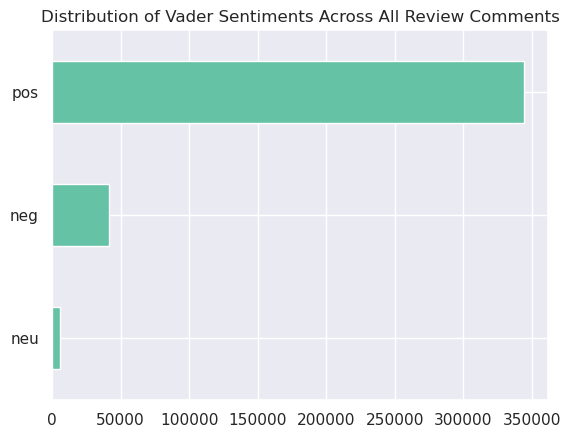

In [132]:
p_all.v_type.value_counts(ascending=True).plot(kind='barh',title="Distribution of Vader Sentiments Across All Review Comments")

We can also perform the above classification at the item-level, for a sample of items with review counts in
different ranges as done previously.

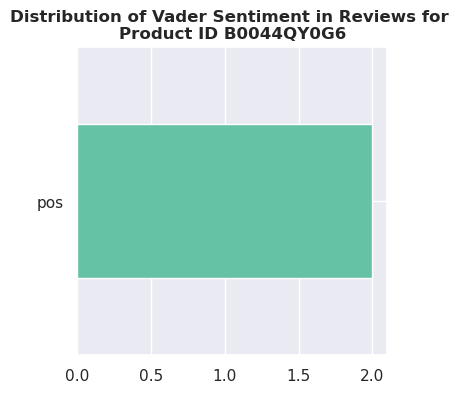

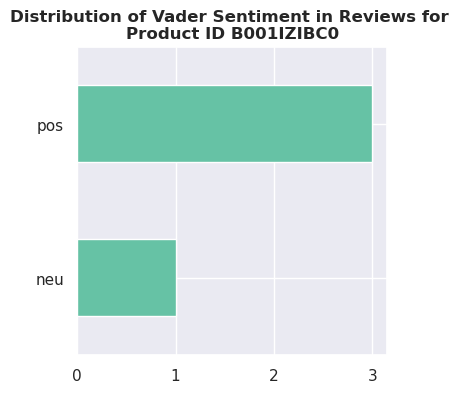

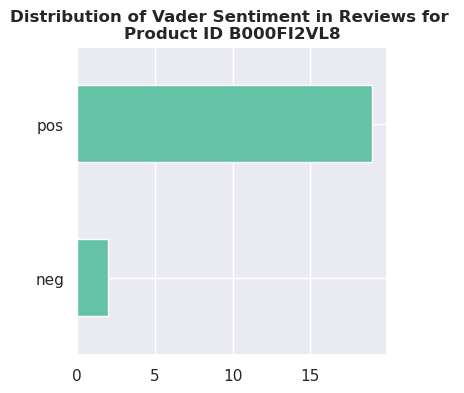

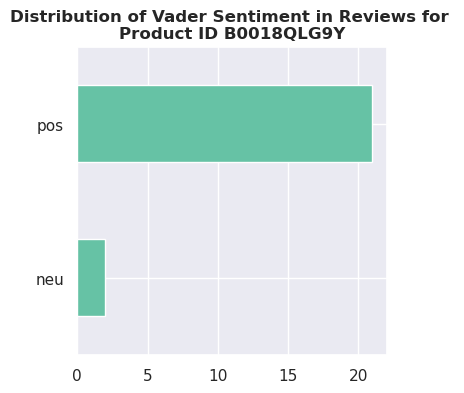

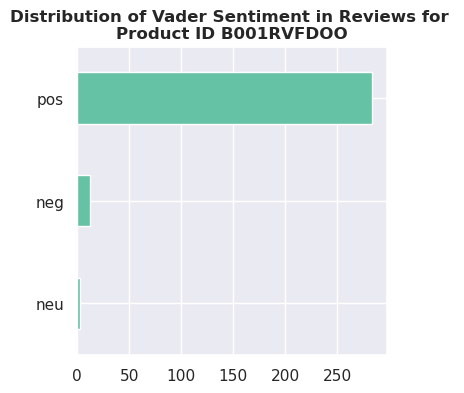

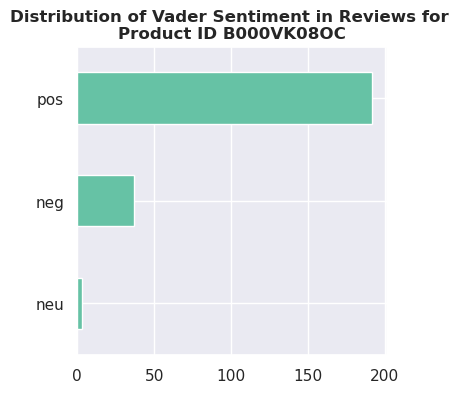

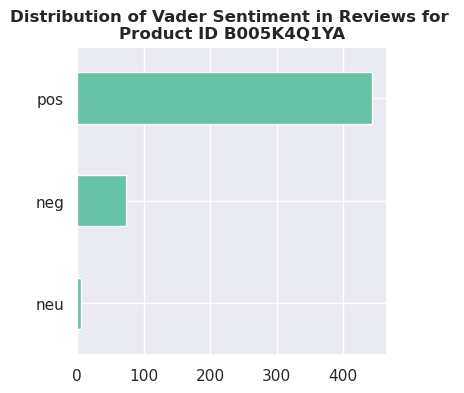

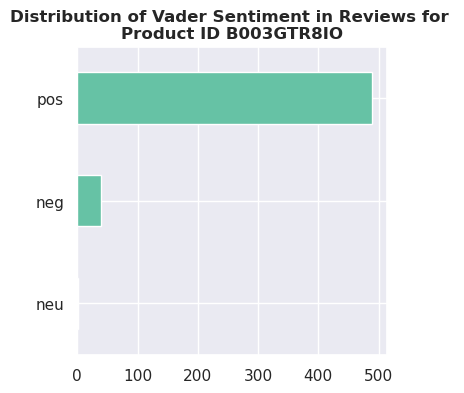

In [133]:
for idx in ps:
    
    v_freq = p_all[p_all['pid']==idx]['v_type'].value_counts()
    
    plt.figure(figsize=(4, 4))
    v_freq.sort_values().plot(kind='barh')   
    plt.title('Distribution of Vader Sentiment in Reviews for \nProduct ID ' + str(idx), fontweight='bold', fontsize=12)

For each product, we find the most frequent vader score (positive/negative) across all review comments and find
the most frequent score category.   

The distribution of the vader sentiments across all products is shown below.

In [134]:
v_list = []

for idx in pdf_count.index:
    
    v_list.append(p_all[p_all['pid']==idx]['v_type'].value_counts().index[0])
    
pdf_count['v_type'] = v_list

Text(0.5, 1.0, 'Distribution of Vander Sentiment across Products')

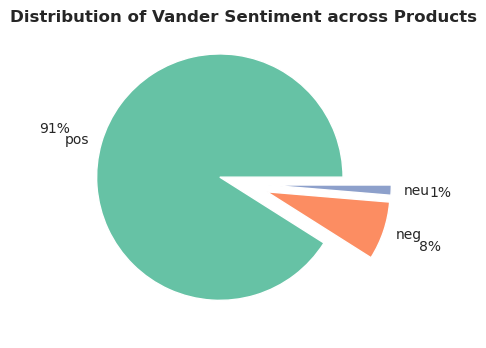

In [135]:
v_freq = pdf_count['v_type'].value_counts()

plt.figure(figsize=(4, 4))
plt.pie(v_freq, labels=v_freq.index, autopct='%1.0f%%', pctdistance=1.4, explode=0.2*np.ones(len(sub_freq)),textprops={'fontsize': 10})
plt.title('Distribution of Vander Sentiment across Products', fontweight='bold', fontsize=12)

We find that for 91% products, the majority review sentiment is positive.  

Finally, for deeper probing, we can generate lists of products which have majority vader sentiment positive or
negative, as shown below.

In [136]:
pdf_count[pdf_count['v_type']=='pos'].index[:10].to_list()

['B007JFMH8M',
 'B003B3OOPA',
 'B0026RQTGE',
 'B001EO5Q64',
 'B000KV61FC',
 'B000VK8AVK',
 'B000NMJWZO',
 'B003GTR8IO',
 'B005K4Q1YA',
 'B000UBD88A']

In [137]:
pdf_count[pdf_count['v_type']=='neg'].index[:10].to_list()

['B00004RAMY',
 'B006N3I69A',
 'B000FBMFDO',
 'B004H3N2LU',
 'B000PGE032',
 'B001B1KH1Y',
 'B00002N8SM',
 'B004Z33GI6',
 'B00004RBDW',
 'B00004RAMS']

## Conclusion  

In conclusion, we note the following.  

1. We found that 75% items had less than 4 reviews and around 75% users have reviewed just one item. Sparse reviews are insufficient for robust conclusions. The firm can incentivize reviewing. 


2. Among the reviewed items, scores 4 and 5 are most frequent. However, a significant fraction of items do have
a score of 1, which could be probed deeper.  

3. We classified items as,

    a. **Best performing**: High review count, High mean/median score  
    b. **Worst performing**: High review count, Low mean/median score  
    
    and users as,  

    a. **Engaged and satisfied**: Large review counts, High mean scores  
    b. **Engaged and dissatisfied**: Large review counts, Low mean scores  
    c. **Unengaged and satisfied**: Small review counts, High mean scores  
    d. **Unengaged and dissatisfied**: Small review counts, Low mean scores  

    We found frequency % for each class above and also generated lists of actual items/users in each class.  

4. We found distributions of subjectivity and polarity as yielded by TextBlob library at different levels: overall comments, product, across products, etc. Most reviews/products had medium subjectivity and positive sentiment associated with them.  

5. We found distributions of compound score as yielded by Vader library at different levels: overall comments, product, across products, etc. Most reviews/products had positive sentiment associated with them.  

### Future Analysis  

As next-level, finer analysis, we can,  

a. Probe deeper into item and user-level review metrics to triangulate automated sentiment scores and
understand specific strengths and weaknesses of items, and review priorities of users.   

b. Perform aspect or entity based sentiment analysis to find sentiments towards a specific product feature.   

c. Mine deeper details about user-based sentiment analysis to generate user profiles.  

d. Tokenize, lemmatize text reviews for deeper model-based analysis.  

e. Apply LSTM, transformer-based models to predict review sentiments.    

### References  

https://www.analyticsvidhya.com/blog/2022/07/sentiment-analysis-using-python/  
https://www.kaggle.com/datasets/bittlingmayer/amazonreviews  
https://textblob.readthedocs.io/en/dev/quickstart.html#  
https://github.com/cjhutto/vaderSentiment  
https://medium.com/@piocalderon/vader-sentiment-analysis-explained-f1c4f9101cd9  
https://www.analyticsvidhya.com/blog/2021/06/text-preprocessing-in-nlp-with-python-codes/  